In [1]:
import regex as re
import gc
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading the clean train and test dataset

train_data = pd.read_pickle('basic_clean_train.pkl')
test_data = pd.read_pickle('basic_clean_test.pkl')

In [3]:
print("*"*35)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*35)

***********************************

 Train Data Shape : (590540, 160) 


 Test Data Shape : (506691, 159) 

***********************************


## Feature Engineering
<br>

### Transaction Minute Feature
<br>

In [4]:
train_data['TransactionMT'] = (train_data['TransactionDT']//60)%60
test_data['TransactionMT'] = (test_data['TransactionDT']//60)%60

In [5]:
# https://stackoverflow.com/questions/34615854/seaborn-countplot-with-normalized-y-axis-per-group

normMT = (train_data.groupby(['isFraud'])['TransactionMT']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

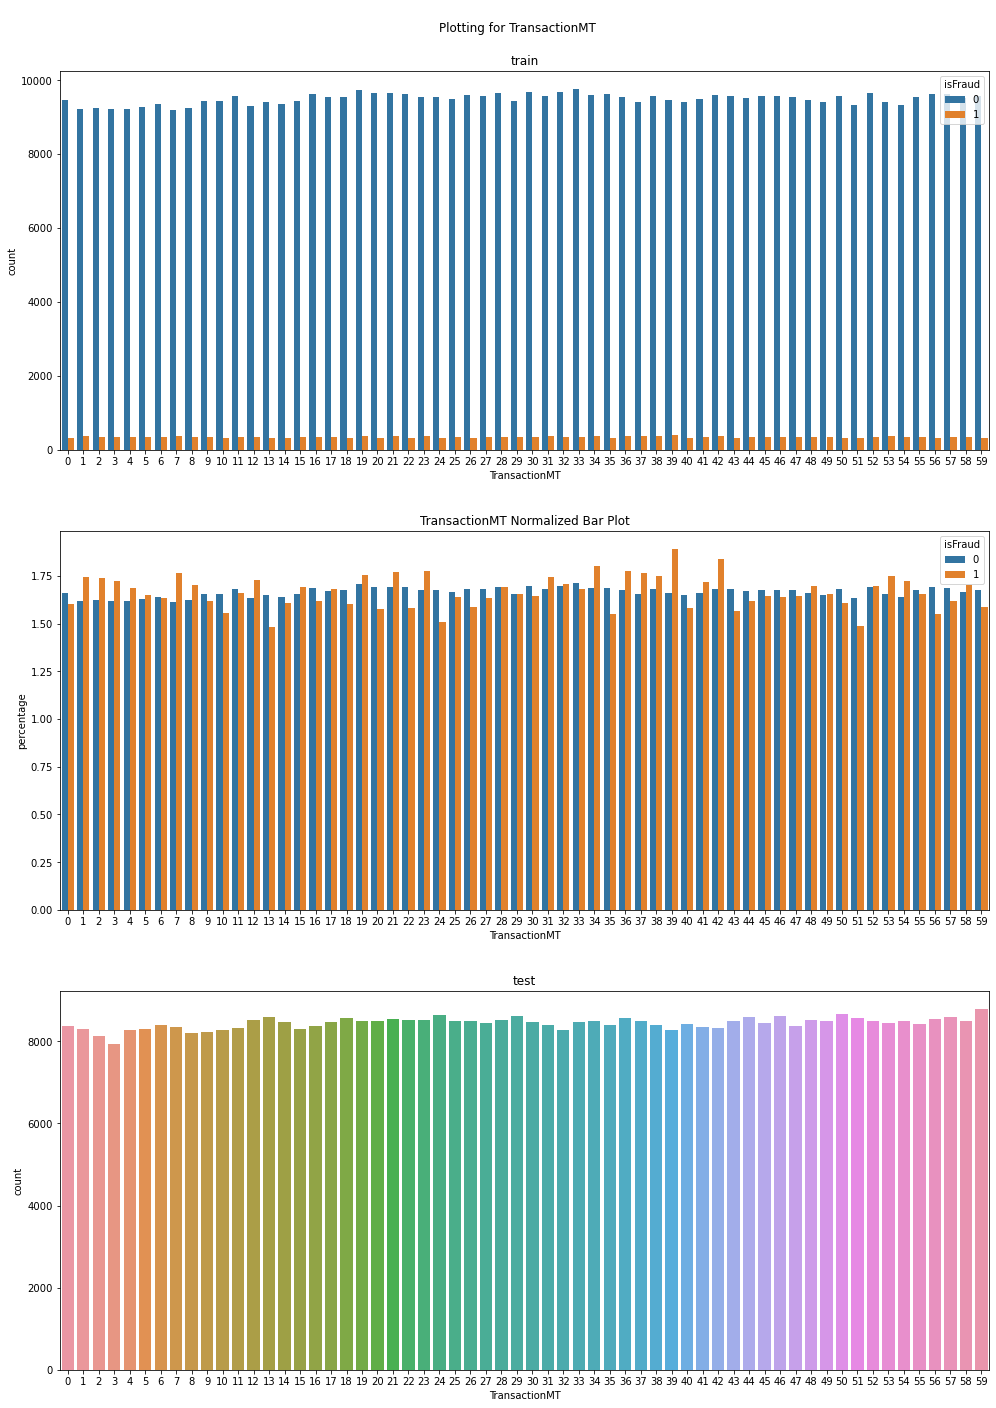

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(15,20))
fig.tight_layout(pad=6.0)
plt.suptitle("\nPlotting for TransactionMT\n", y=1)

sns.countplot(x='TransactionMT', hue='isFraud', data=train_data, ax=ax[0])
ax[0].set_title('train')

sns.barplot(x="TransactionMT", y="percentage", hue="isFraud", data=normMT, ax=ax[1])
ax[1].set_title("TransactionMT Normalized Bar Plot")

sns.countplot(x='TransactionMT', data=test_data, ax=ax[2])
ax[2].set_title('test')

plt.show()

__Observation(s):__

1. TransactionMT feature does not seem to be very useful in deciding the Transaction Status since the percentage of fraudulent and non-fraudulent transactions for each of the 60 minutes is almost same.
<br><br>

In [7]:
# https://datascience.stackexchange.com/questions/5990/what-is-a-good-way-to-transform-cyclic-ordinal-attributes

# Adding Cyclic Nature of Minutes

train_data['TransactionMT_X'] = np.sin(2.*np.pi*train_data['TransactionMT']/60.)
train_data['TransactionMT_Y'] = np.cos(2.*np.pi*train_data['TransactionMT']/60.)

test_data['TransactionMT_X'] = np.sin(2.*np.pi*test_data['TransactionMT']/60.)
test_data['TransactionMT_Y'] = np.cos(2.*np.pi*test_data['TransactionMT']/60.)

### Transaction Hour Feature
<br>

In [8]:
train_data['TransactionHR'] = (train_data['TransactionDT']//3600)%24
test_data['TransactionHR'] = (test_data['TransactionDT']//3600)%24

In [9]:
normHR = (train_data.groupby(['isFraud'])['TransactionHR']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

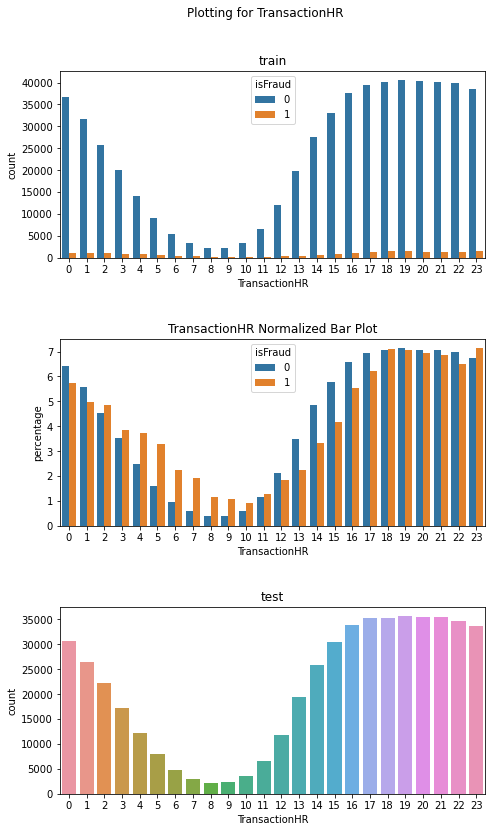

In [10]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for TransactionHR", y=1)

ax[0].set_title('train')
sns.countplot(x='TransactionHR', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("TransactionHR Normalized Bar Plot")
sns.barplot(x="TransactionHR", y="percentage", hue="isFraud", data=normHR, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='TransactionHR', data=test_data, ax=ax[2])

plt.show()

__Observation(s):__

1. The distribution of "TransactionHR" feature seems very simlar to the "D9" feature. Let's plot it also for more clarity.


2. The relationship between the hour with total number of transactions and the total number of fraudulent transactions is exactly inverse. The larger the number of transactions in an hour the lesser is the fraud percentage of that hour and the lesser the total number of transactions the higher is the fraud percentage.
<br><br>

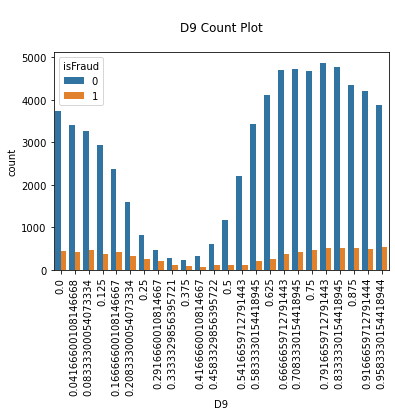

In [11]:
sns.countplot(x='D9', hue='isFraud', data=train_data)
plt.title("\nD9 Count Plot\n")
plt.xticks(rotation=90)
plt.show()

__Observation(s):__ 

1. "D9" feature is nothing but the TransactionHR feature whose xticks have been normalized between 0 and 1.


2. A difference in the count of fraud and non-fraud transactions can be seen between both the plots, this is because we have a large number of rows having no information regarding "D9" feature. Hence, instead of using "D9" feature with missig values we can simply use the "TrasanctionHR" feature with no missing values.
<br><br>



In [12]:
# Adding Cyclic Nature of Hours

train_data['TransactionHR_X'] = np.sin(2.*np.pi*train_data['TransactionHR']/24.)
train_data['TransactionHR_Y'] = np.cos(2.*np.pi*train_data['TransactionHR']/24.)

test_data['TransactionHR_X'] = np.sin(2.*np.pi*test_data['TransactionHR']/24.)
test_data['TransactionHR_Y'] = np.cos(2.*np.pi*test_data['TransactionHR']/24.)

### TransactionDay Feature
<br>

TransactionDay gives us the exact day on which a transaction happened, since TransactionDT is the time elapsed from a given reference time and this reference time is the time when everything started.

Since, TransactionDT is the time in seconds so we can say that TransactionDT corresponds to the number of seconds elapsed since everything started. Now, if we can convert these seconds into days and consider the first day as 0th day then we can find the day for all other transactions relative to the first day.
<br><br>

In [13]:
train_data['TransactionDay'] = train_data['TransactionDT']//(24*3600)
test_data['TransactionDay'] = test_data['TransactionDT']//(24*3600)

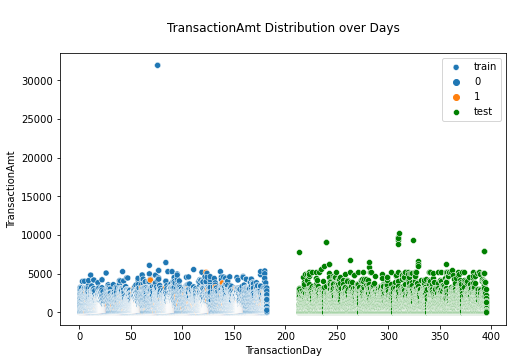

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(y='TransactionAmt', x='TransactionDay', hue='isFraud', data=train_data, label='train', c=['r','b'])
sns.scatterplot(y='TransactionAmt', x='TransactionDay', data=test_data, label='test', c=['g'])
plt.title('\nTransactionAmt Distribution over Days\n')
plt.show()

__Observations(s):__ From the above plot, it is quite clear that we have some outliers in train data having TransactionAmt > 3000. We can simply drop such rows from the dataset.
<br><br>

In [15]:
train_data = train_data[train_data['TransactionAmt']<30000]

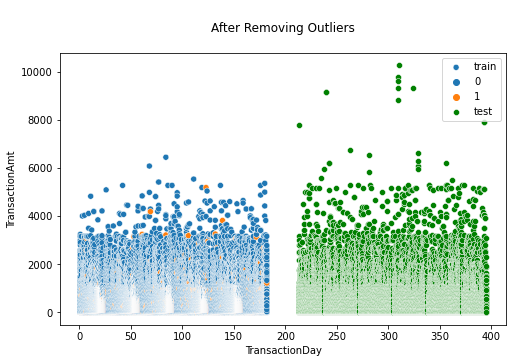

In [16]:
plt.figure(figsize=(8, 5))
sns.scatterplot(y='TransactionAmt', x='TransactionDay', hue='isFraud', data=train_data, label='train', c=['r','b'])
sns.scatterplot(y='TransactionAmt', x='TransactionDay', data=test_data, label='test', c=['g'])
plt.title('\nAfter Removing Outliers\n')
plt.show()

### Transaction Weekday Feature
<br>

In [17]:
train_data['TransactionWD'] = (train_data['TransactionDT']//(24*3600))%7
test_data['TransactionWD'] = (test_data['TransactionDT']//(24*3600))%7

In [18]:
normWD = (train_data.groupby(['isFraud'])['TransactionWD']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

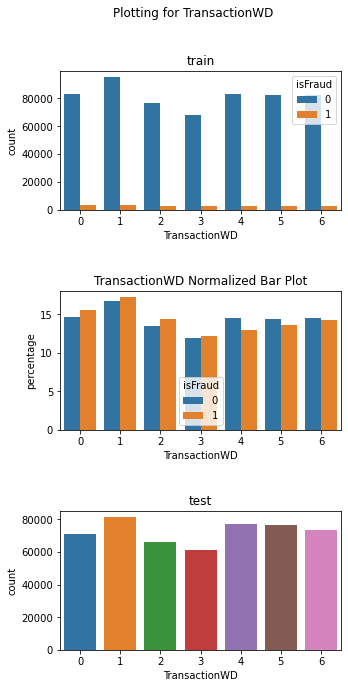

In [19]:
fig, ax = plt.subplots(3,1, figsize=(6,10))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for TransactionWD", y=1)

ax[0].set_title('train')
sns.countplot(x='TransactionWD', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("TransactionWD Normalized Bar Plot")
sns.barplot(x="TransactionWD", y="percentage", hue="isFraud", data=normWD, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='TransactionWD', data=test_data, ax=ax[2])

plt.show()

__Observation(s):__

1. TransactionWD feature does not seem to be very usefuul in deciding the Transaction Status since the percentage of fraudulent and non-fraudulent transactions for each of the 60 minutes is almost same.
<br><br>

### Dollars and Cents Feature
<br>

In [20]:
train_amt_whole = [int(str(a).split('.')[0]) for a in train_data['TransactionAmt'].values]
train_amt_decimal = [int(str(a).split('.')[1]) for a in train_data['TransactionAmt'].values]

test_amt_whole = [int(str(a).split('.')[0]) for a in test_data['TransactionAmt'].values]
test_amt_decimal = [int(str(a).split('.')[1]) for a in test_data['TransactionAmt'].values]

In [21]:
train_data['dollars'] = train_amt_whole
train_data['cents'] = train_amt_decimal

test_data['dollars'] = test_amt_whole
test_data['cents'] = test_amt_decimal

### Natural Logarithm of TransactionAmt
<br>

In [22]:
train_data['TransactionAmt_log'] = np.log(train_data['TransactionAmt'])
test_data['TransactionAmt_log'] = np.log(test_data['TransactionAmt'])

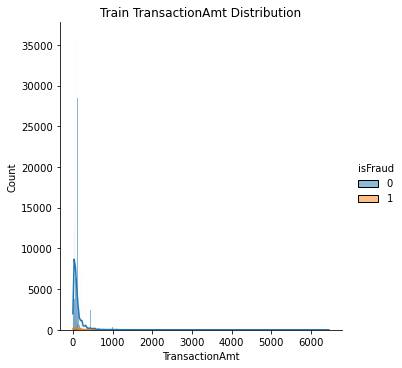

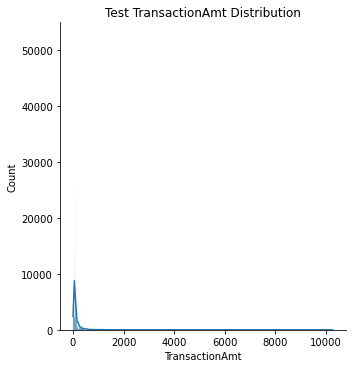

In [23]:
sns.displot(x = 'TransactionAmt', hue='isFraud', data = train_data, kde=True)
plt.title("Train TransactionAmt Distribution")

sns.displot(x = 'TransactionAmt', data = test_data, kde=True)
plt.title("Test TransactionAmt Distribution")

plt.show()

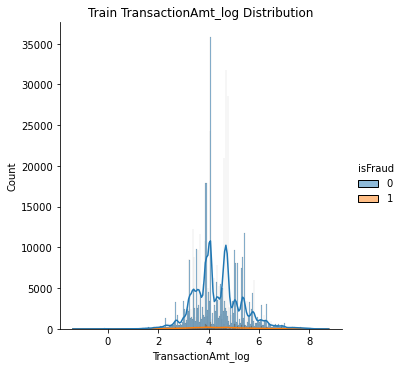

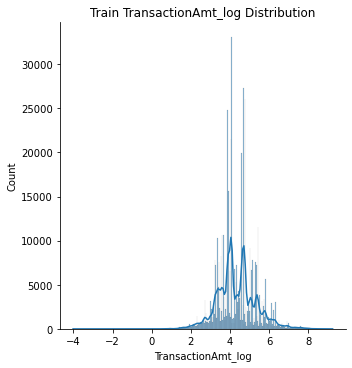

In [24]:
sns.displot(x = 'TransactionAmt_log', hue='isFraud', data = train_data, kde=True)
plt.title("Train TransactionAmt_log Distribution")

sns.displot(x = 'TransactionAmt_log', data = test_data, kde=True)
plt.title("Train TransactionAmt_log Distribution")

plt.show()

### card1_div_1000 Feature
<br>

In [25]:
train_data['card1_div_1000'] = train_data['card1']//1000
test_data['card1_div_1000'] = test_data['card1']//1000

In [26]:
norm_card1_div_1000 = (train_data.groupby(['isFraud'])['card1_div_1000']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

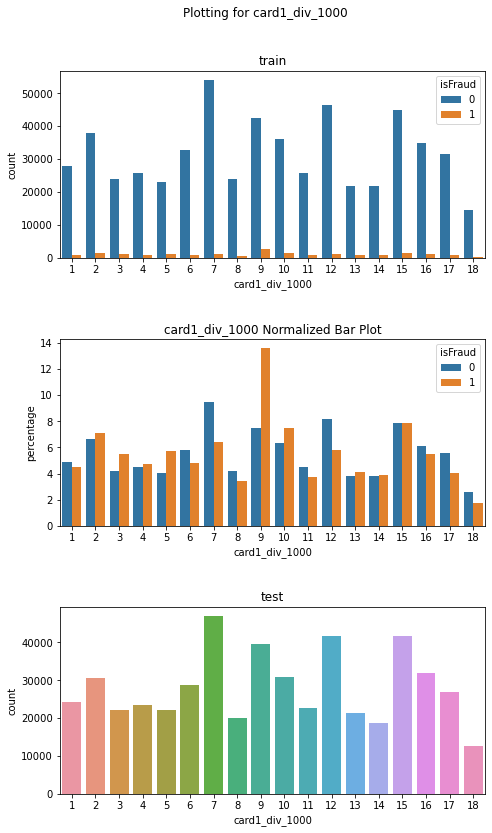

In [27]:
fig, ax = plt.subplots(3,1, figsize=(8,12))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for card1_div_1000", y=1)

ax[0].set_title('train')
sns.countplot(x='card1_div_1000', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("card1_div_1000 Normalized Bar Plot")
sns.barplot(x="card1_div_1000", y="percentage", hue="isFraud", data=norm_card1_div_1000, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='card1_div_1000', data=test_data, ax=ax[2])

plt.show()

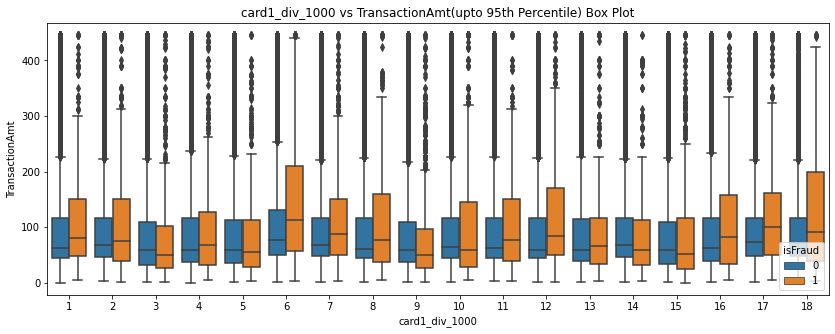

In [28]:
plt.figure(figsize=(14,5))
sns.boxplot(x='card1_div_1000', y='TransactionAmt', hue='isFraud', data=train_data[train_data['TransactionAmt']<=np.percentile(train_data['TransactionAmt'], 95)])
plt.title('card1_div_1000 vs TransactionAmt(upto 95th Percentile) Box Plot')
plt.show()

__Observation(s):__

1. This feature seems to be useful since for each category in this feature a separability between the TransactionAmt for Fraudulent Transactions and Non-Fraudulent Transactions is present.
<br><br>

### card2_div_10
<br>

In [29]:
train_data['card2_div_10'] = train_data['card2']//10
test_data['card2_div_10'] = test_data['card2']//10

In [30]:
norm_card2_div_10 = (train_data.groupby(['isFraud'])['card2_div_10']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

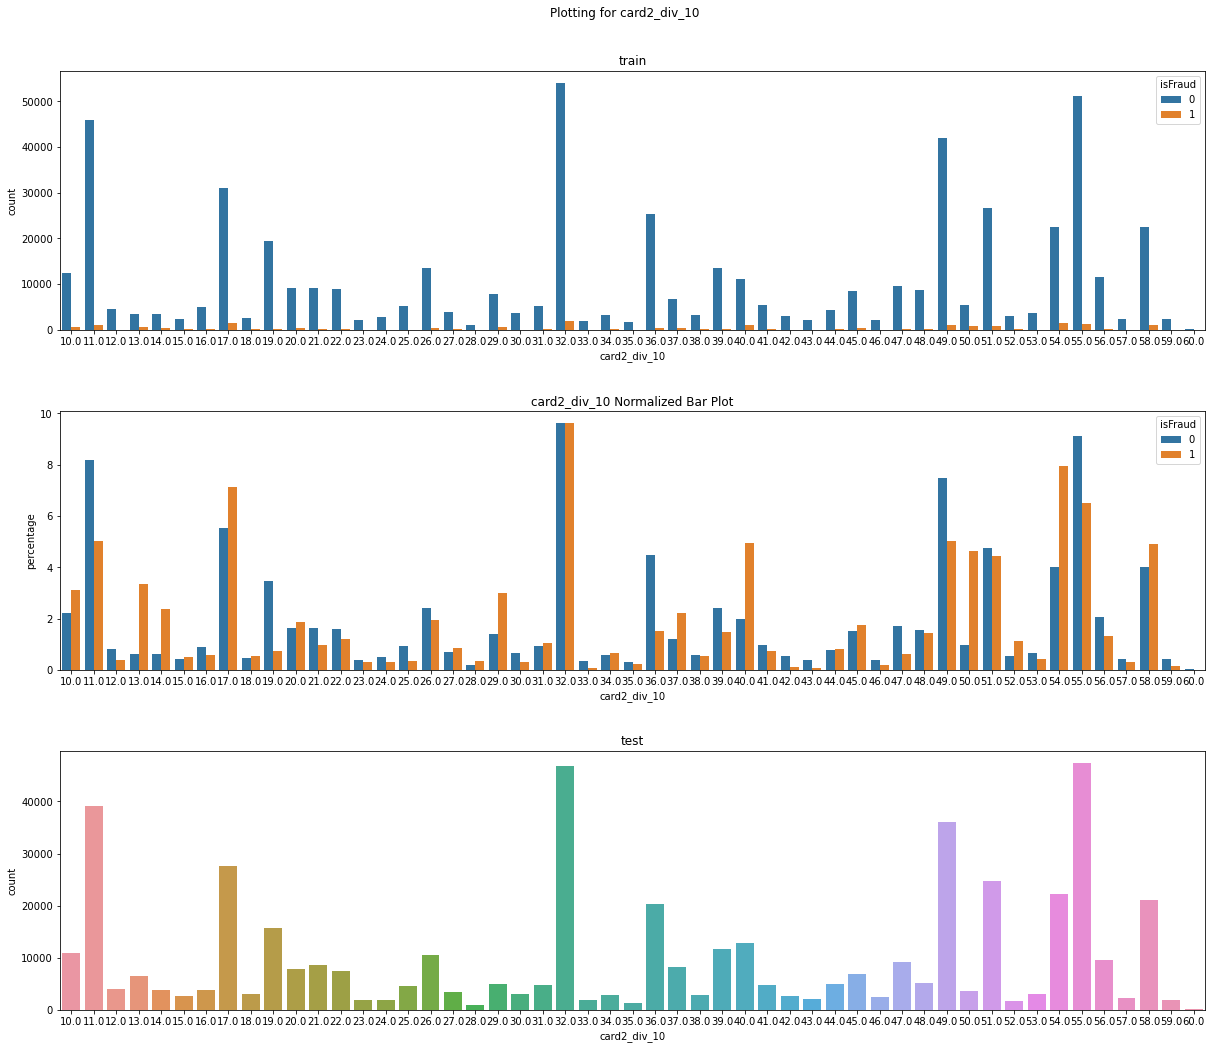

In [31]:
fig, ax = plt.subplots(3,1, figsize=(18,15))
fig.tight_layout(pad=6.0)
fig.suptitle("Plotting for card2_div_10", y=1)

ax[0].set_title('train')
sns.countplot(x='card2_div_10', hue='isFraud', data=train_data, ax=ax[0])

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="card2_div_10", y="percentage", hue="isFraud", data=norm_card2_div_10, ax=ax[1])

ax[2].set_title('test')
sns.countplot(x='card2_div_10', data=test_data, ax=ax[2])

plt.show()

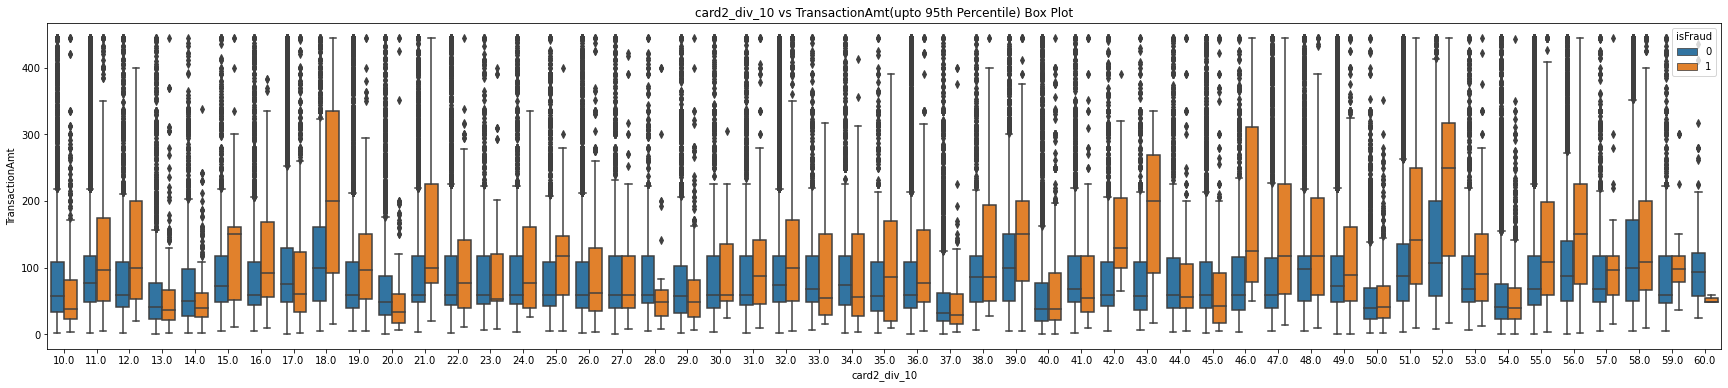

In [32]:
plt.figure(figsize=(30,6))
sns.boxplot(x='card2_div_10', y='TransactionAmt', hue='isFraud', data=train_data[train_data['TransactionAmt']<=np.percentile(train_data['TransactionAmt'], 95)])
plt.title('card2_div_10 vs TransactionAmt(upto 95th Percentile) Box Plot')
plt.show()

__Observation(s):__

1. This feature seems to be useful since for each category in this feature a separability between the TransactionAmt for Fraudulent Transactions and Non-Fraudulent Transactions is present.
<br><br>

### Adding Parent Domain and Splitting Domain Name and Top Level Domain from P_emaildomain
<br>


In [33]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499

parent_domain = {'gmail.com':'gmail', 'outlook.com':'microsoft', 
                 'yahoo.com':'yahoo', 'mail.com':'mail', 'anonymous.com':'anonymous', 
                 'hotmail.com':'microsoft', 'verizon.net':'verizon', 'aol.com':'aol', 
                 'me.com':'apple', 'comcast.net':'comcast', 'optonline.net':'optimum', 
                 'cox.net':'cox', 'charter.net':'spectrum', 'rocketmail.com':'yahoo', 
                 'prodigy.net.mx':'AT&T', 'embarqmail.com':'century_link', 'icloud.com':'apple', 
                 'live.com.mx':'microsoft', 'gmail':'gmail', 'live.com':'microsoft', 
                 'att.net':'AT&T', 'juno.com':'juno', 'ymail.com':'yahoo', 
                 'sbcglobal.net':'sbcglobal', 'bellsouth.net':'AT&T', 'msn.com':'microsoft', 
                 'q.com':'century_link','yahoo.com.mx':'yahoo', 'centurylink.net':'century_link',  
                 'servicios-ta.com':'asur','earthlink.net':'earthlink', 'hotmail.es':'microsoft', 
                 'cfl.rr.com':'spectrum', 'roadrunner.com':'spectrum','netzero.net':'netzero', 
                 'gmx.de':'gmx','suddenlink.net':'suddenlink','frontiernet.net':'frontier', 
                 'windstream.net':'windstream','frontier.com':'frontier','outlook.es':'microsoft', 
                 'mac.com':'apple','netzero.com':'netzero','aim.com':'aol', 
                 'web.de':'web_de','twc.com':'whois','cableone.net':'sparklight', 
                 'yahoo.fr':'yahoo','yahoo.de':'yahoo','yahoo.es':'yahoo', 'scranton.edu':'scranton', 
                 'sc.rr.com':'sc_rr','ptd.net':'ptd','live.fr':'microsoft', 
                 'yahoo.co.uk':'yahoo','hotmail.fr':'microsoft','hotmail.de':'microsoft', 
                 'hotmail.co.uk':'microsoft','protonmail.com':'protonmail','yahoo.co.jp':'yahoo'}

In [34]:
train_P_emaildomain = train_data['P_emaildomain']
test_P_emaildomain = test_data['P_emaildomain']

train_data['P_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in train_P_emaildomain] 
test_data['P_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in test_P_emaildomain]

train_data['P_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in train_P_emaildomain]
test_data['P_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in test_P_emaildomain]

train_data['P_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in train_P_emaildomain]
test_data['P_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in test_P_emaildomain]

In [35]:
norm_P_parent_domain = (train_data.groupby(['isFraud'])['P_parent_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

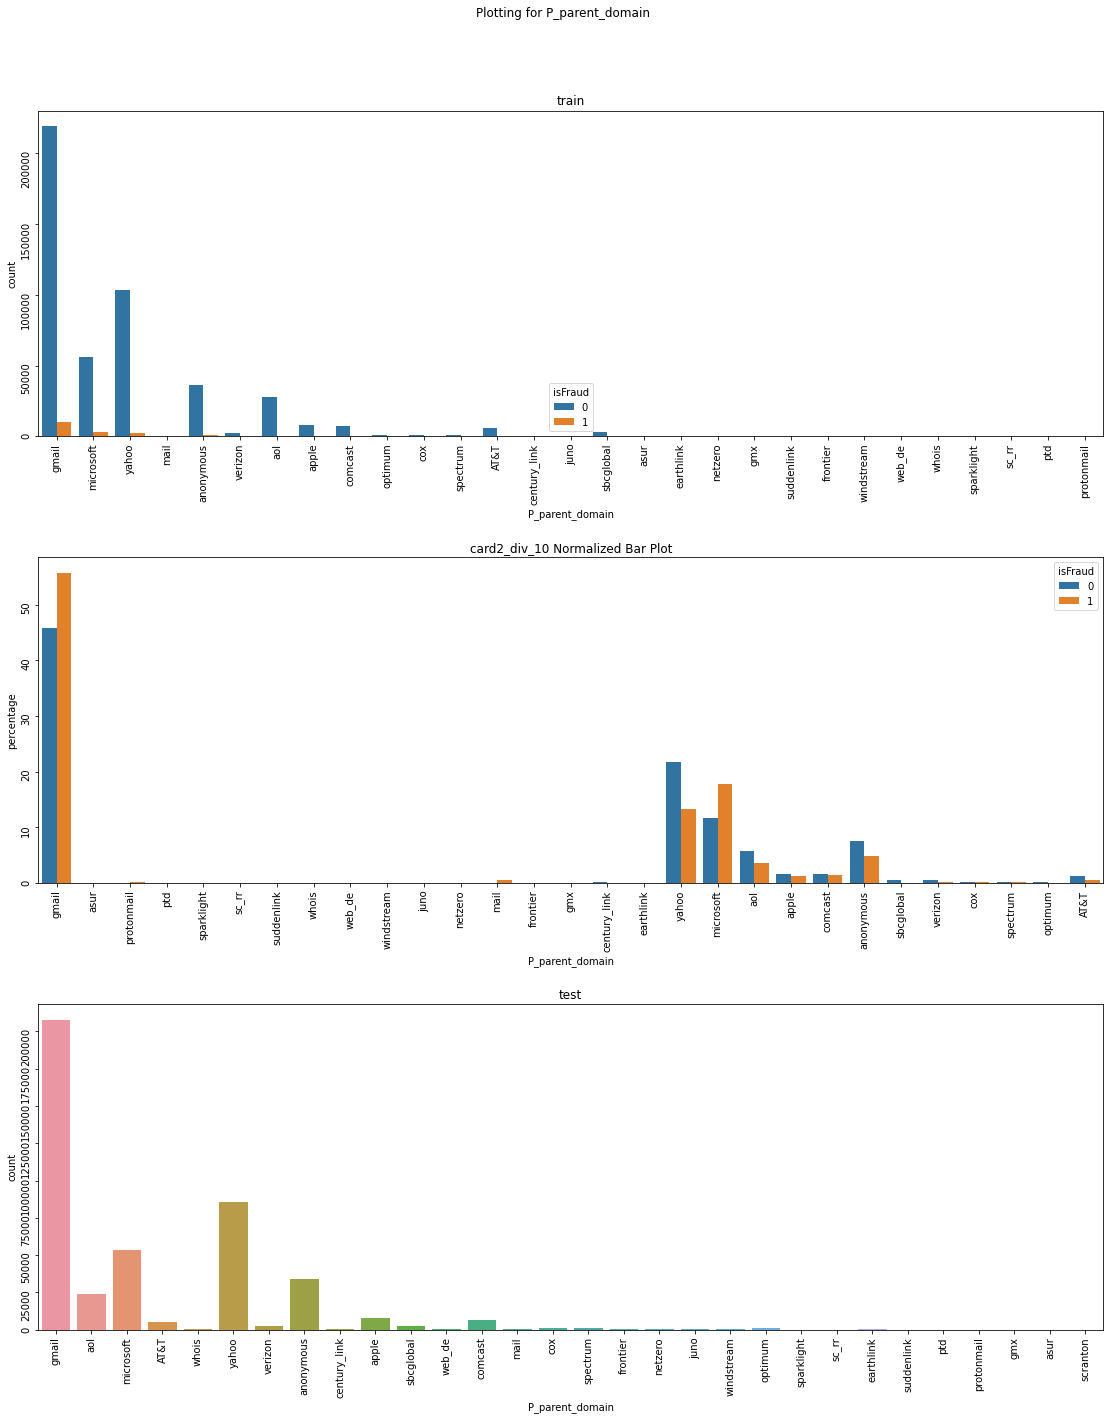

In [36]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_parent_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='P_parent_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="P_parent_domain", y="percentage", hue="isFraud", data=norm_P_parent_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_parent_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [37]:
norm_P_domain_name = (train_data.groupby(['isFraud'])['P_domain_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

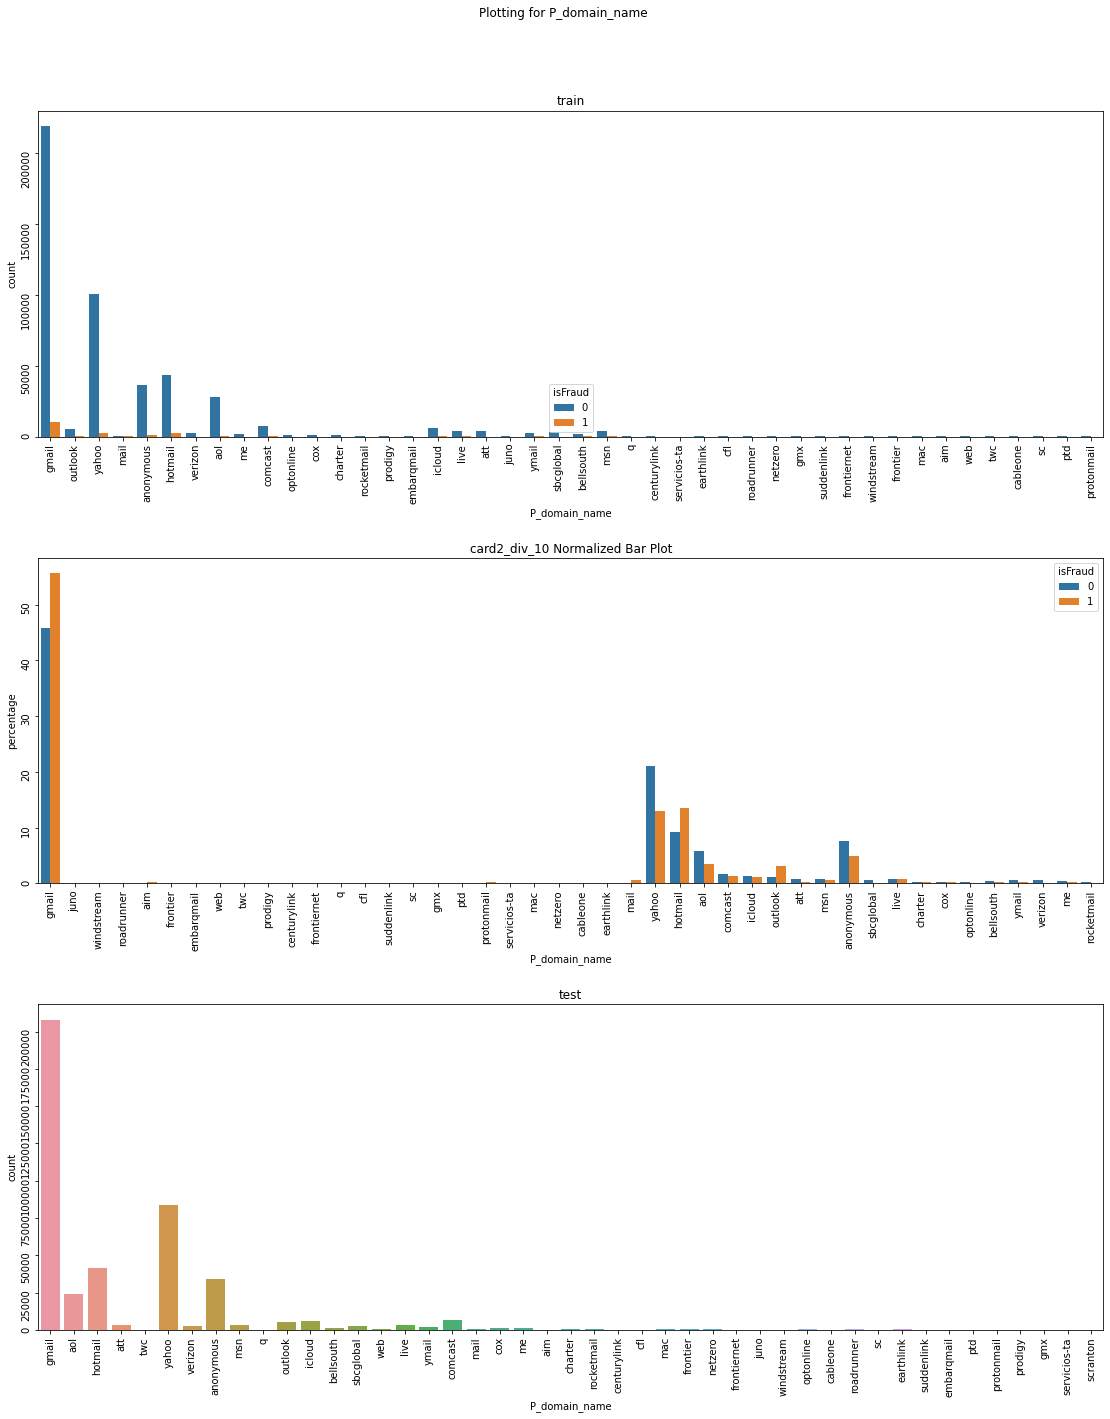

In [38]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_domain_name", y=1)

ax[0].set_title('train')
sns.countplot(x='P_domain_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="P_domain_name", y="percentage", hue="isFraud", data=norm_P_domain_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_domain_name', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [39]:
norm_P_top_level_domain = (train_data.groupby(['isFraud'])['P_top_level_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

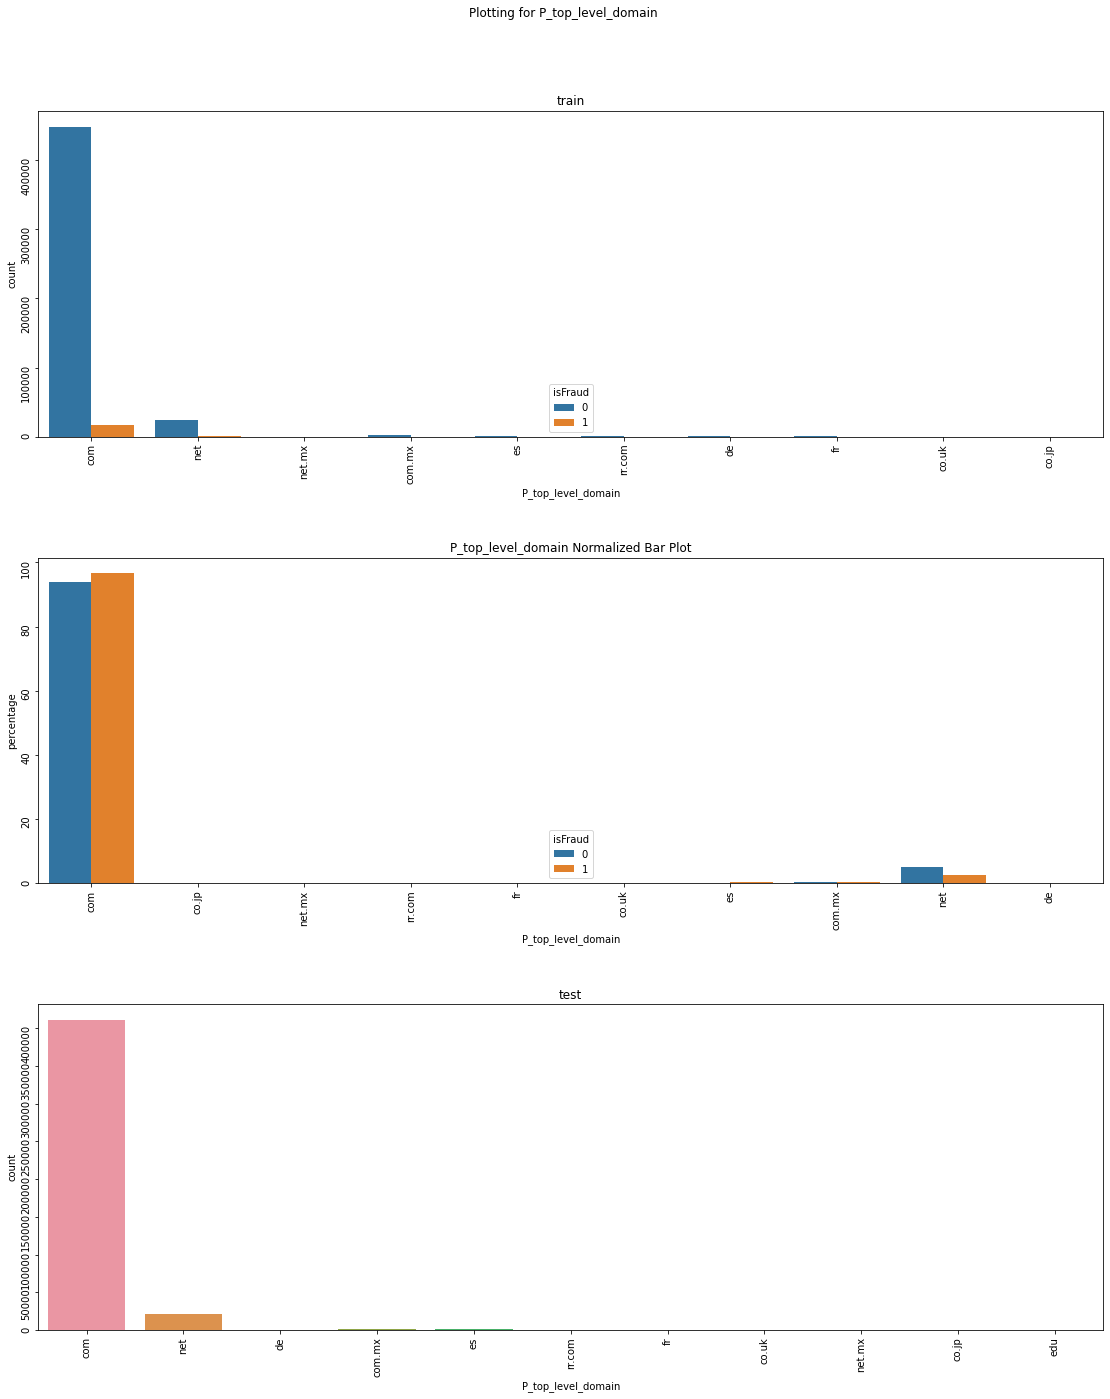

In [40]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for P_top_level_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='P_top_level_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("P_top_level_domain Normalized Bar Plot")
sns.barplot(x="P_top_level_domain", y="percentage", hue="isFraud", data=norm_P_top_level_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='P_top_level_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

### Adding Parent Domain and Splitting Domain Name and Top Level Domain from R_emaildomain
<br>


In [41]:
train_R_emaildomain = train_data['R_emaildomain']
test_R_emaildomain = test_data['R_emaildomain']

train_data['R_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in train_R_emaildomain] 
test_data['R_parent_domain'] = [np.nan if pd.isna(domain) else parent_domain[domain] for domain in test_R_emaildomain]

train_data['R_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in train_R_emaildomain]
test_data['R_domain_name'] = [np.nan if pd.isna(addrs) else addrs.split('.')[0] for addrs in test_R_emaildomain]

train_data['R_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in train_R_emaildomain]
test_data['R_top_level_domain'] = [np.nan if (pd.isna(addrs)) or (len(addrs.split('.'))<=1) else '.'.join(addrs.split('.')[1:]) for addrs in test_R_emaildomain]

In [42]:
norm_R_parent_domain = (train_data.groupby(['isFraud'])['R_parent_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

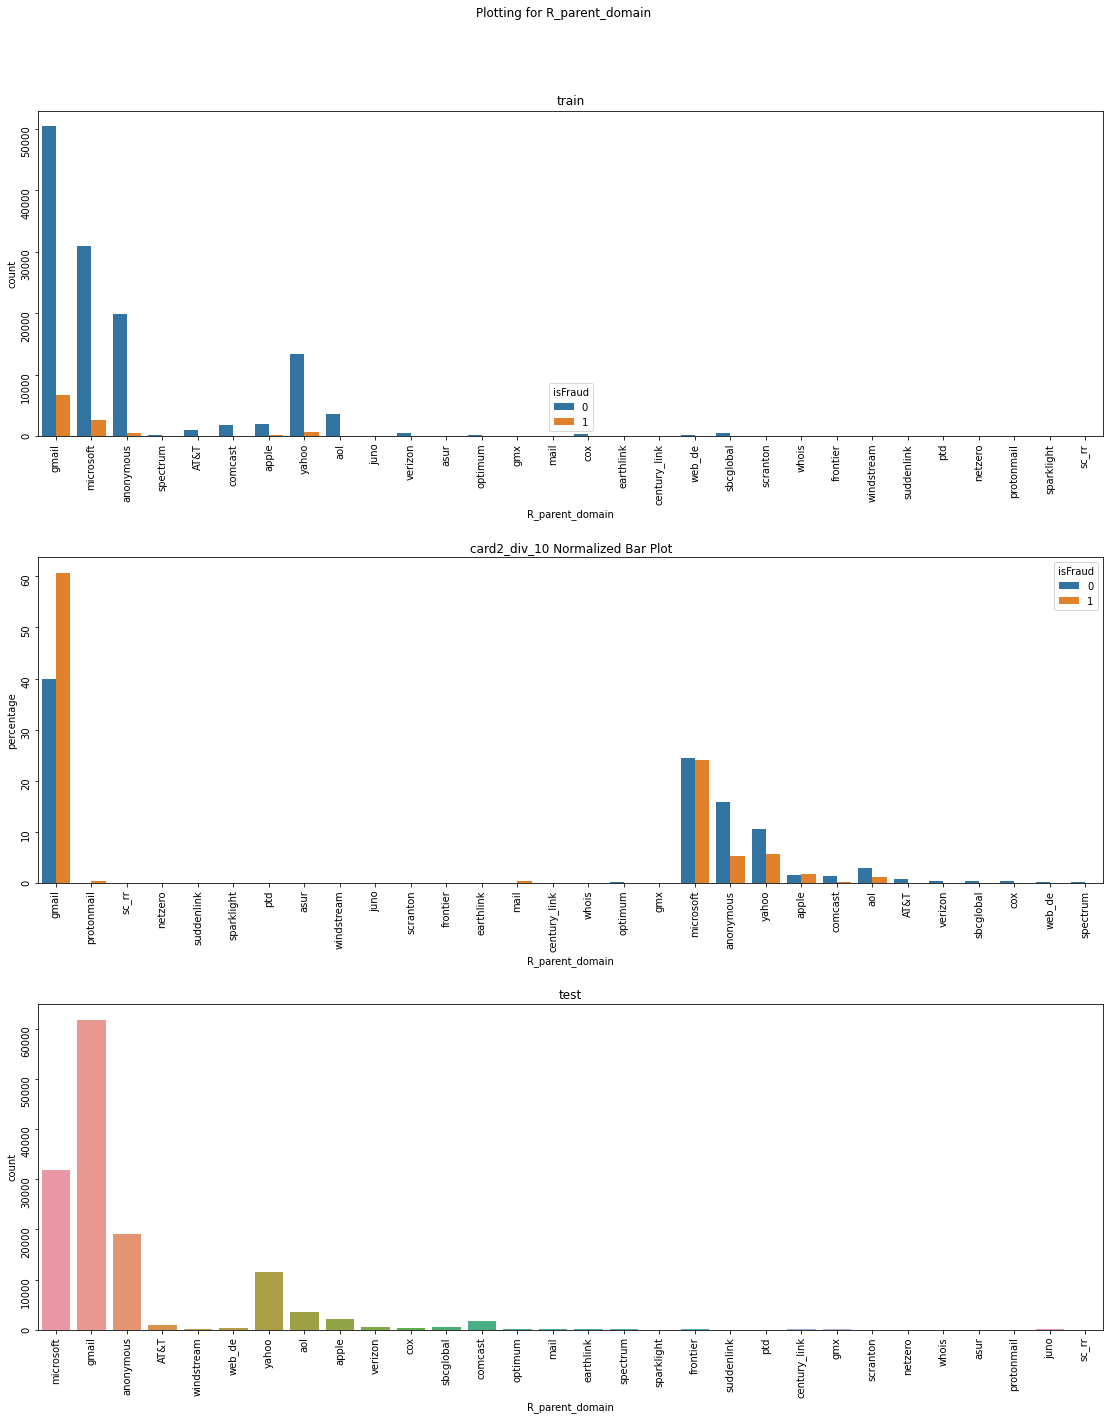

In [43]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_parent_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='R_parent_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="R_parent_domain", y="percentage", hue="isFraud", data=norm_R_parent_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_parent_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [44]:
norm_R_domain_name = (train_data.groupby(['isFraud'])['R_domain_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

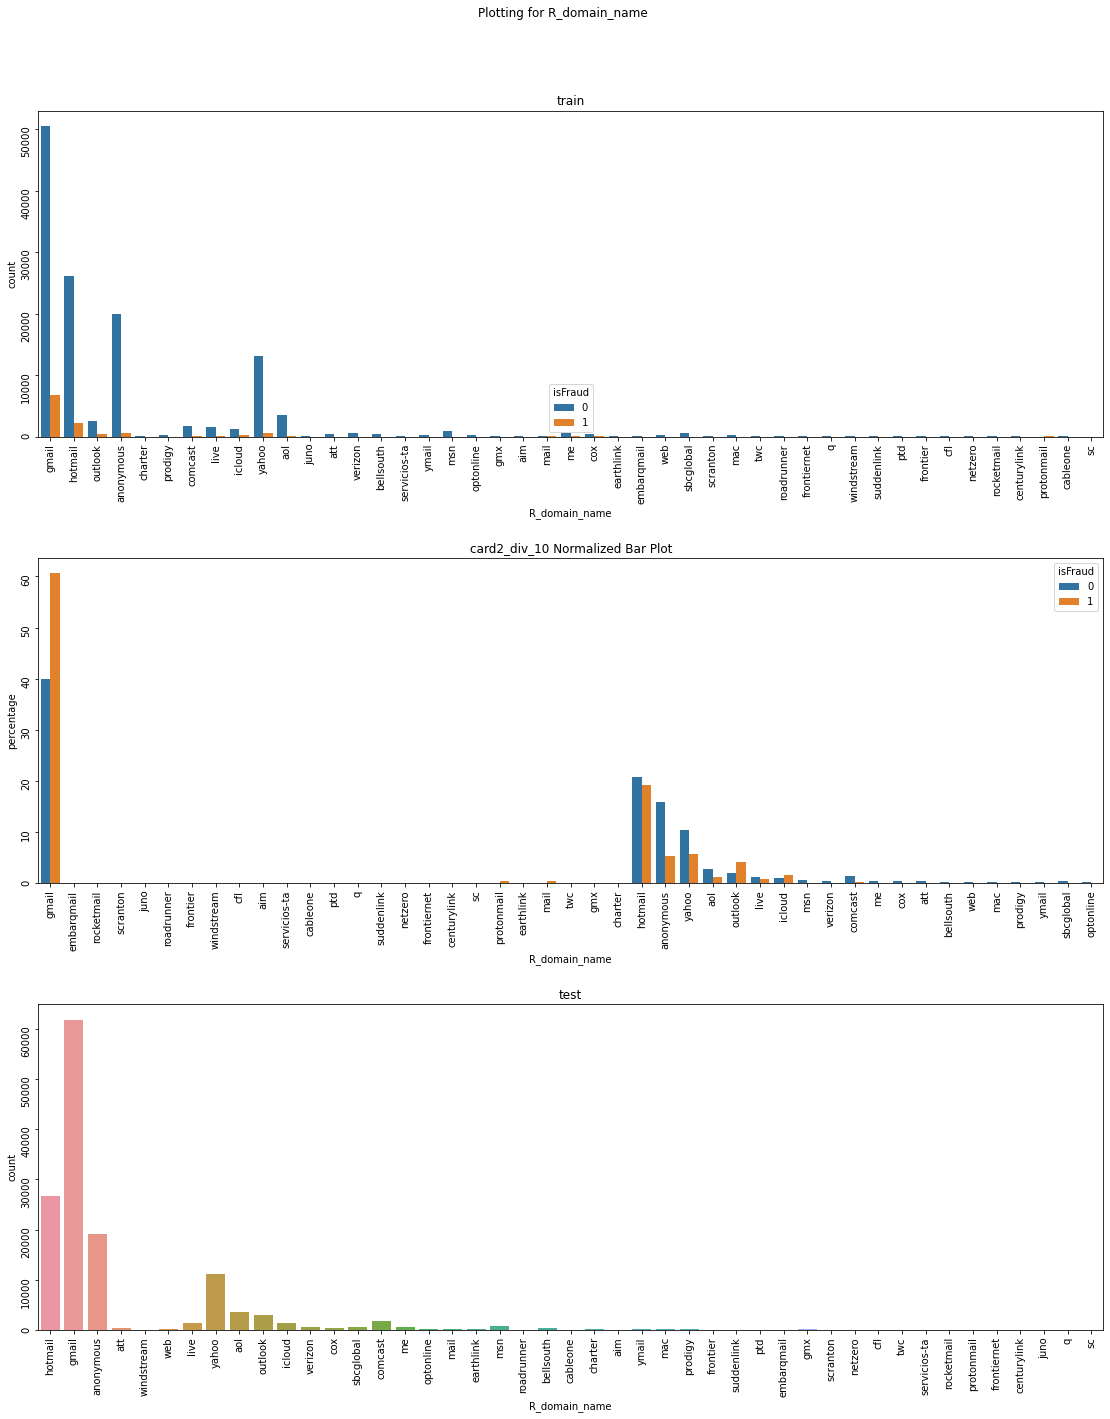

In [45]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_domain_name", y=1)

ax[0].set_title('train')
sns.countplot(x='R_domain_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("card2_div_10 Normalized Bar Plot")
sns.barplot(x="R_domain_name", y="percentage", hue="isFraud", data=norm_R_domain_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_domain_name', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

In [46]:
norm_R_top_level_domain = (train_data.groupby(['isFraud'])['R_top_level_domain']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

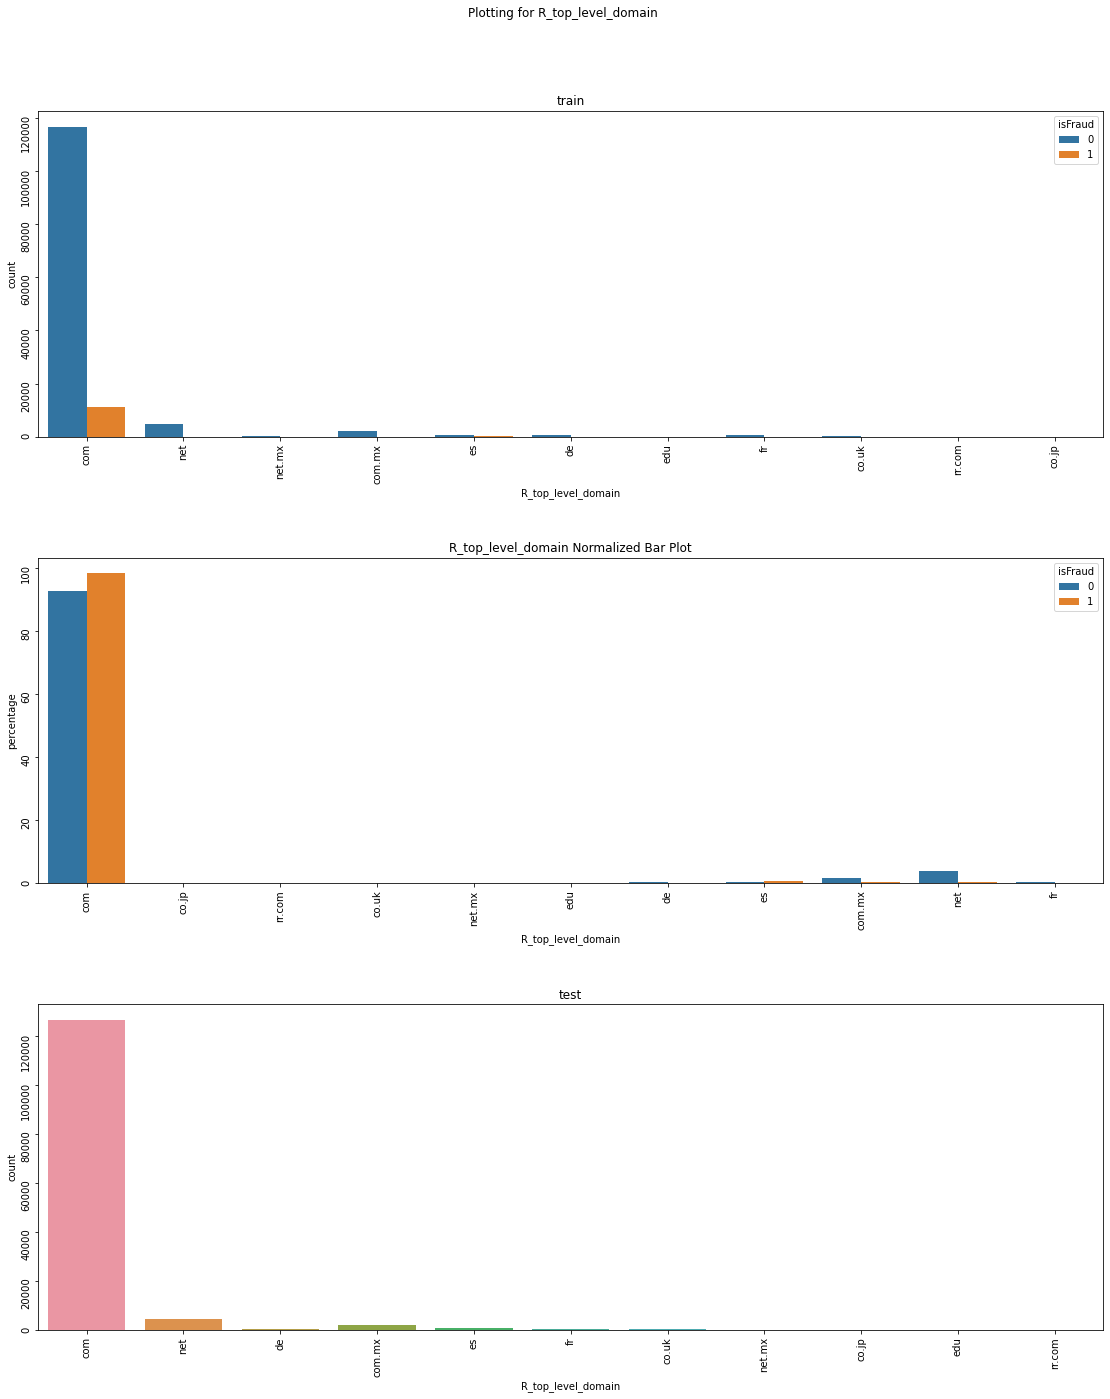

In [47]:
fig, ax = plt.subplots(3,1, figsize=(18,20))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for R_top_level_domain", y=1)

ax[0].set_title('train')
sns.countplot(x='R_top_level_domain', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("R_top_level_domain Normalized Bar Plot")
sns.barplot(x="R_top_level_domain", y="percentage", hue="isFraud", data=norm_R_top_level_domain, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title('test')
sns.countplot(x='R_top_level_domain', data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)


plt.show()

### Device Parent Company and Device Version Features
<br>

In [48]:
# https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm?select=submission.csv

def parent_device_name(df):
  '''
    Utility Function to map deice name to its parent company.
  '''

  if(df['device_name'].isna().all()):
        return df
    
  df.loc[df['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
  df.loc[df['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
  df.loc[df['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
  df.loc[df['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
  df.loc[df['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
  df.loc[df['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
  df.loc[df['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
  df.loc[df['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
  df.loc[df['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
  df.loc[df['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
  df.loc[df['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
  df.loc[df.device_name.isin(df.device_name.value_counts()[df.device_name.value_counts() < 200].index), 'device_name'] = "Others"

  return df

In [49]:
train_data['device_name'] = [np.nan if pd.isna(v) else v.split('/')[0] for v in train_data['DeviceInfo'].values]
test_data['device_name'] = [np.nan if pd.isna(v) else v.split('/')[0] for v in test_data['DeviceInfo'].values]

train_data['device_version'] = [np.nan if (pd.isna(v)) or (len(v.split('/'))<=1) else v.split('/')[1] for v in train_data['DeviceInfo'].values]
test_data['device_version'] = [np.nan if (pd.isna(v)) or (len(v.split('/'))<=1) else v.split('/')[1] for v in test_data['DeviceInfo'].values]

train_data = parent_device_name(train_data)
test_data = parent_device_name(test_data)

In [50]:
norm_device_name = (train_data.groupby(['isFraud'])['device_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

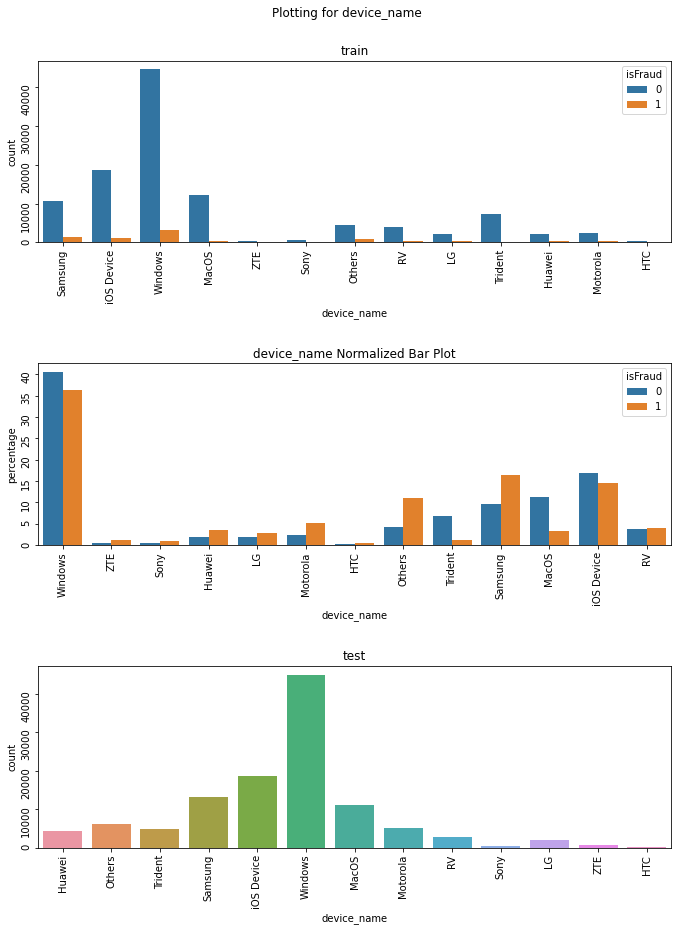

In [51]:
fig, ax = plt.subplots(3,1, figsize=(12,14))
fig.tight_layout(pad=10.0)
fig.suptitle("Plotting for device_name", y=0.95)

ax[0].set_title('train')
sns.countplot(x='device_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("device_name Normalized Bar Plot")
sns.barplot(x="device_name", y="percentage", hue="isFraud", data=norm_device_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="device_name", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

In [52]:
norm_device_version = (train_data.groupby(['isFraud'])['device_version']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

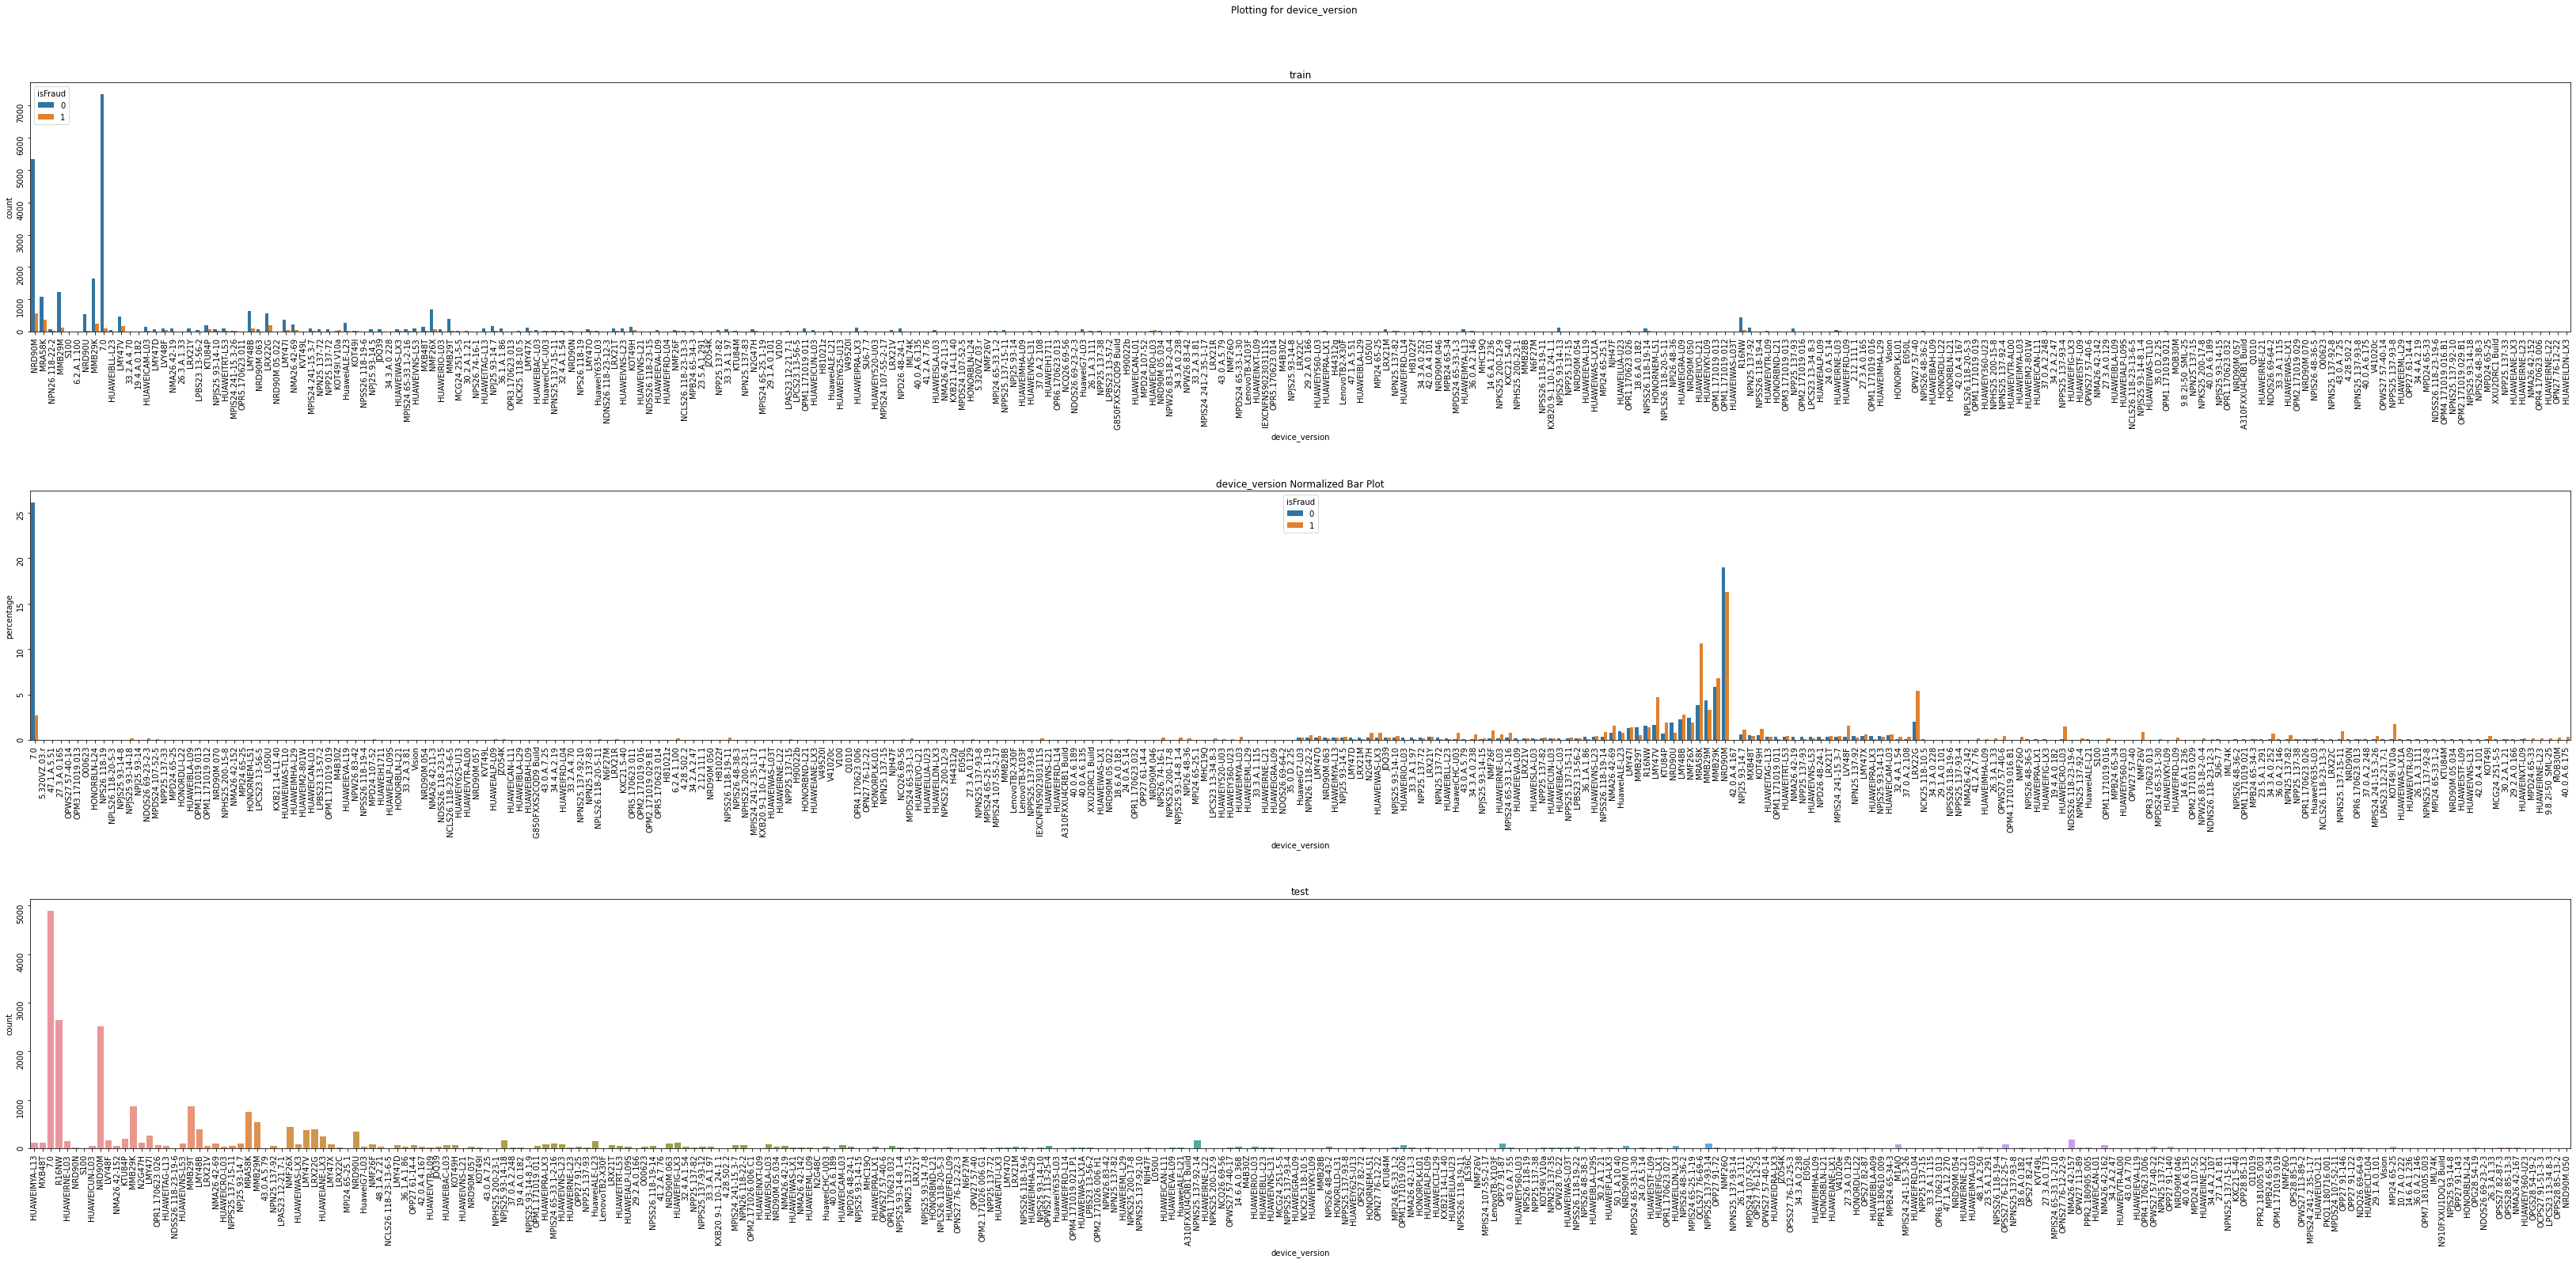

In [53]:
fig, ax = plt.subplots(3,1, figsize=(50,24))
fig.tight_layout(pad=18.0)
fig.suptitle("Plotting for device_version", y=0.95)

ax[0].set_title('train')
sns.countplot(x='device_version', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("device_version Normalized Bar Plot")
sns.barplot(x="device_version", y="percentage", hue="isFraud", data=norm_device_version, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="device_version", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

### os_name and os_version features
<br>

In [54]:
train_data['os_name'] = [info if (pd.isna(info)) or (len(info.split())<=1) else ' '.join(info.split()[:-1]) for info in train_data['id_30']]
test_data['os_name'] = [info if (pd.isna(info)) or (len(info.split())<=1) else ' '.join(info.split()[:-1]) for info in test_data['id_30']]

train_data['os_version'] = [np.nan if (pd.isna(info)) or (len(info.split())<=1) else info.split()[-1] for info in train_data['id_30']]
test_data['os_version'] = [np.nan if (pd.isna(info)) or (len(info.split())<=1) else info.split()[-1] for info in test_data['id_30']]

In [55]:
norm_os_name = (train_data.groupby(['isFraud'])['os_name']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

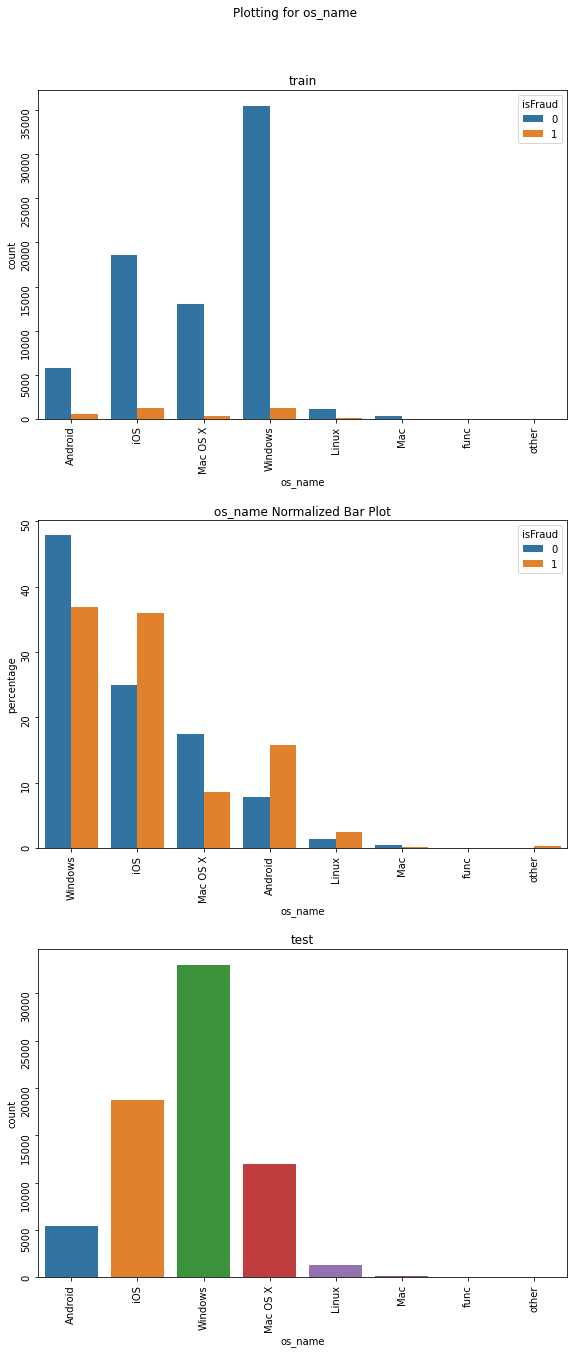

In [56]:
fig, ax = plt.subplots(3,1, figsize=(10,19))
fig.tight_layout(pad=8.0)
fig.suptitle("Plotting for os_name", y=1)

ax[0].set_title('train')
sns.countplot(x='os_name', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("os_name Normalized Bar Plot")
sns.barplot(x="os_name", y="percentage", hue="isFraud", data=norm_os_name, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="os_name", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

In [57]:
norm_os_version = (train_data.groupby(['isFraud'])['os_version']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

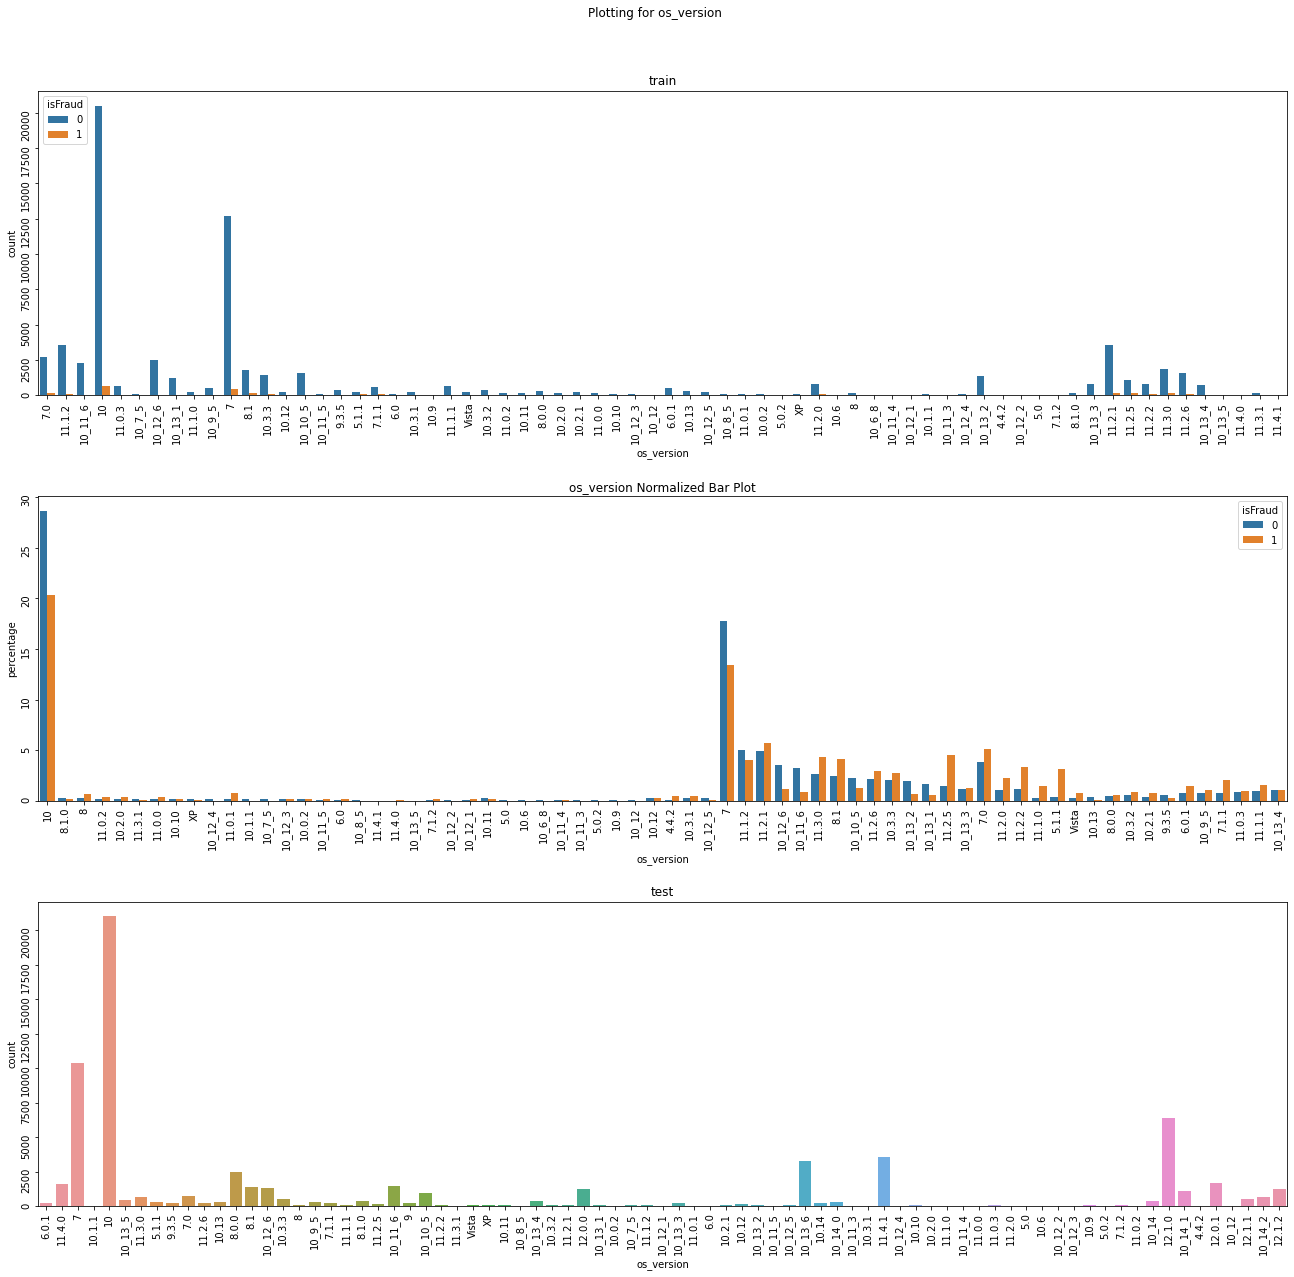

In [58]:
fig, ax = plt.subplots(3,1, figsize=(20,18))
fig.tight_layout(pad=8.0)
fig.suptitle("Plotting for os_version", y=1)

ax[0].set_title('train')
sns.countplot(x='os_version', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("os_version Normalized Bar Plot")
sns.barplot(x="os_version", y="percentage", hue="isFraud", data=norm_os_version, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="os_version", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

### Screen Width and Height Features
<br>

In [59]:
train_data['screen_width'] = [np.nan if pd.isna(v) else v.split('x')[0] for v in train_data['id_33'].values]
test_data['screen_width'] = [np.nan if pd.isna(v) else v.split('x')[0] for v in test_data['id_33'].values]

train_data['screen_height'] = [np.nan if (pd.isna(v)) or len(v.split('x'))<=1 else v.split('x')[1] for v in train_data['id_33'].values]
test_data['screen_height'] = [np.nan if (pd.isna(v)) or len(v.split('x'))<=1 else v.split('x')[1] for v in test_data['id_33'].values]

In [60]:
norm_screen_width = (train_data.groupby(['isFraud'])['screen_width']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

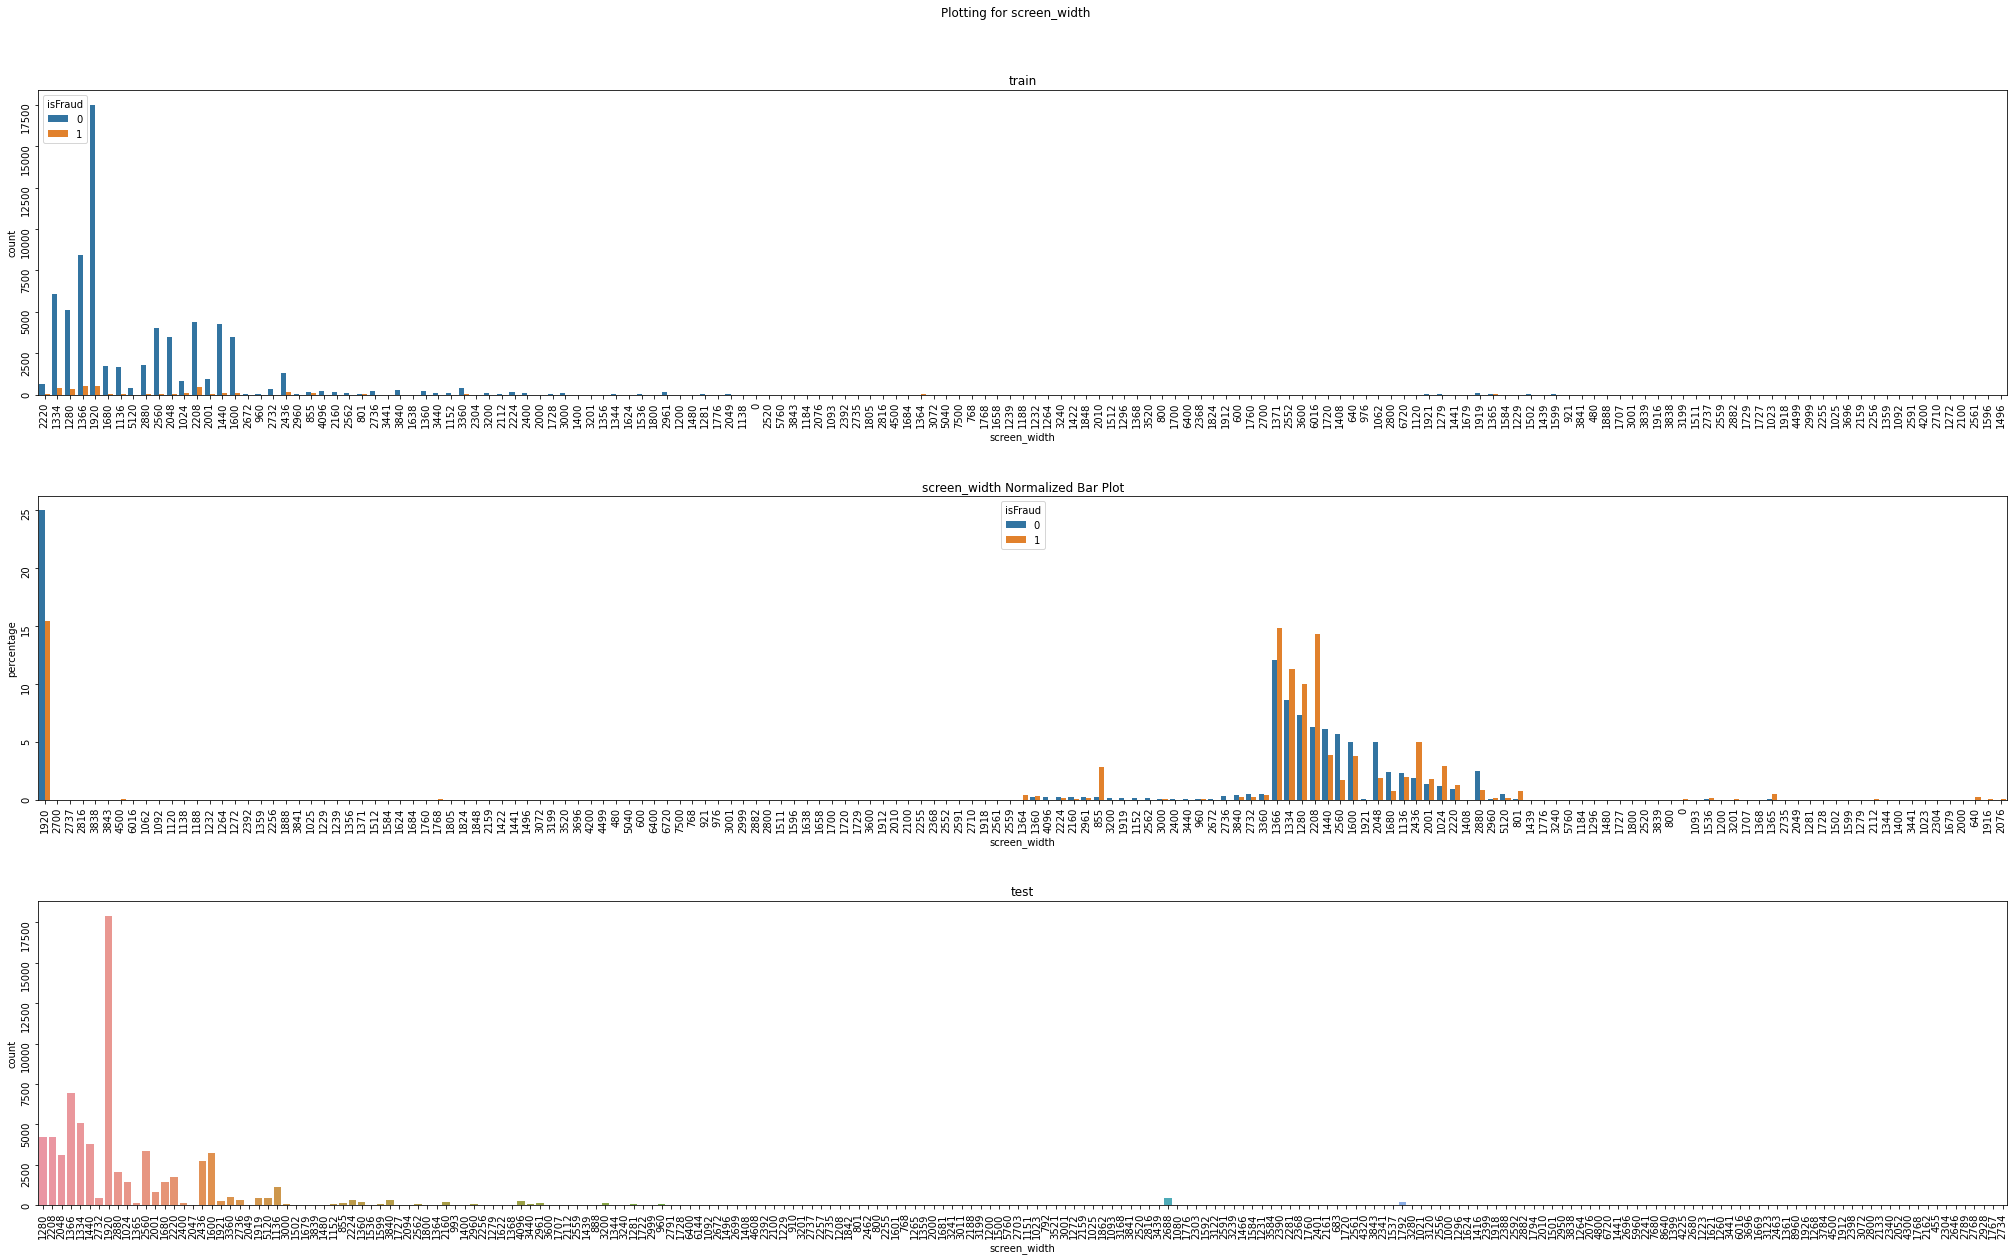

In [61]:
fig, ax = plt.subplots(3,1, figsize=(30,18))
fig.tight_layout(pad=8.0)
fig.suptitle("Plotting for screen_width", y=1)

ax[0].set_title('train')
sns.countplot(x='screen_width', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("screen_width Normalized Bar Plot")
sns.barplot(x="screen_width", y="percentage", hue="isFraud", data=norm_screen_width, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="screen_width", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

In [62]:
norm_screen_height = (train_data.groupby(['isFraud'])['screen_height']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('isFraud'))

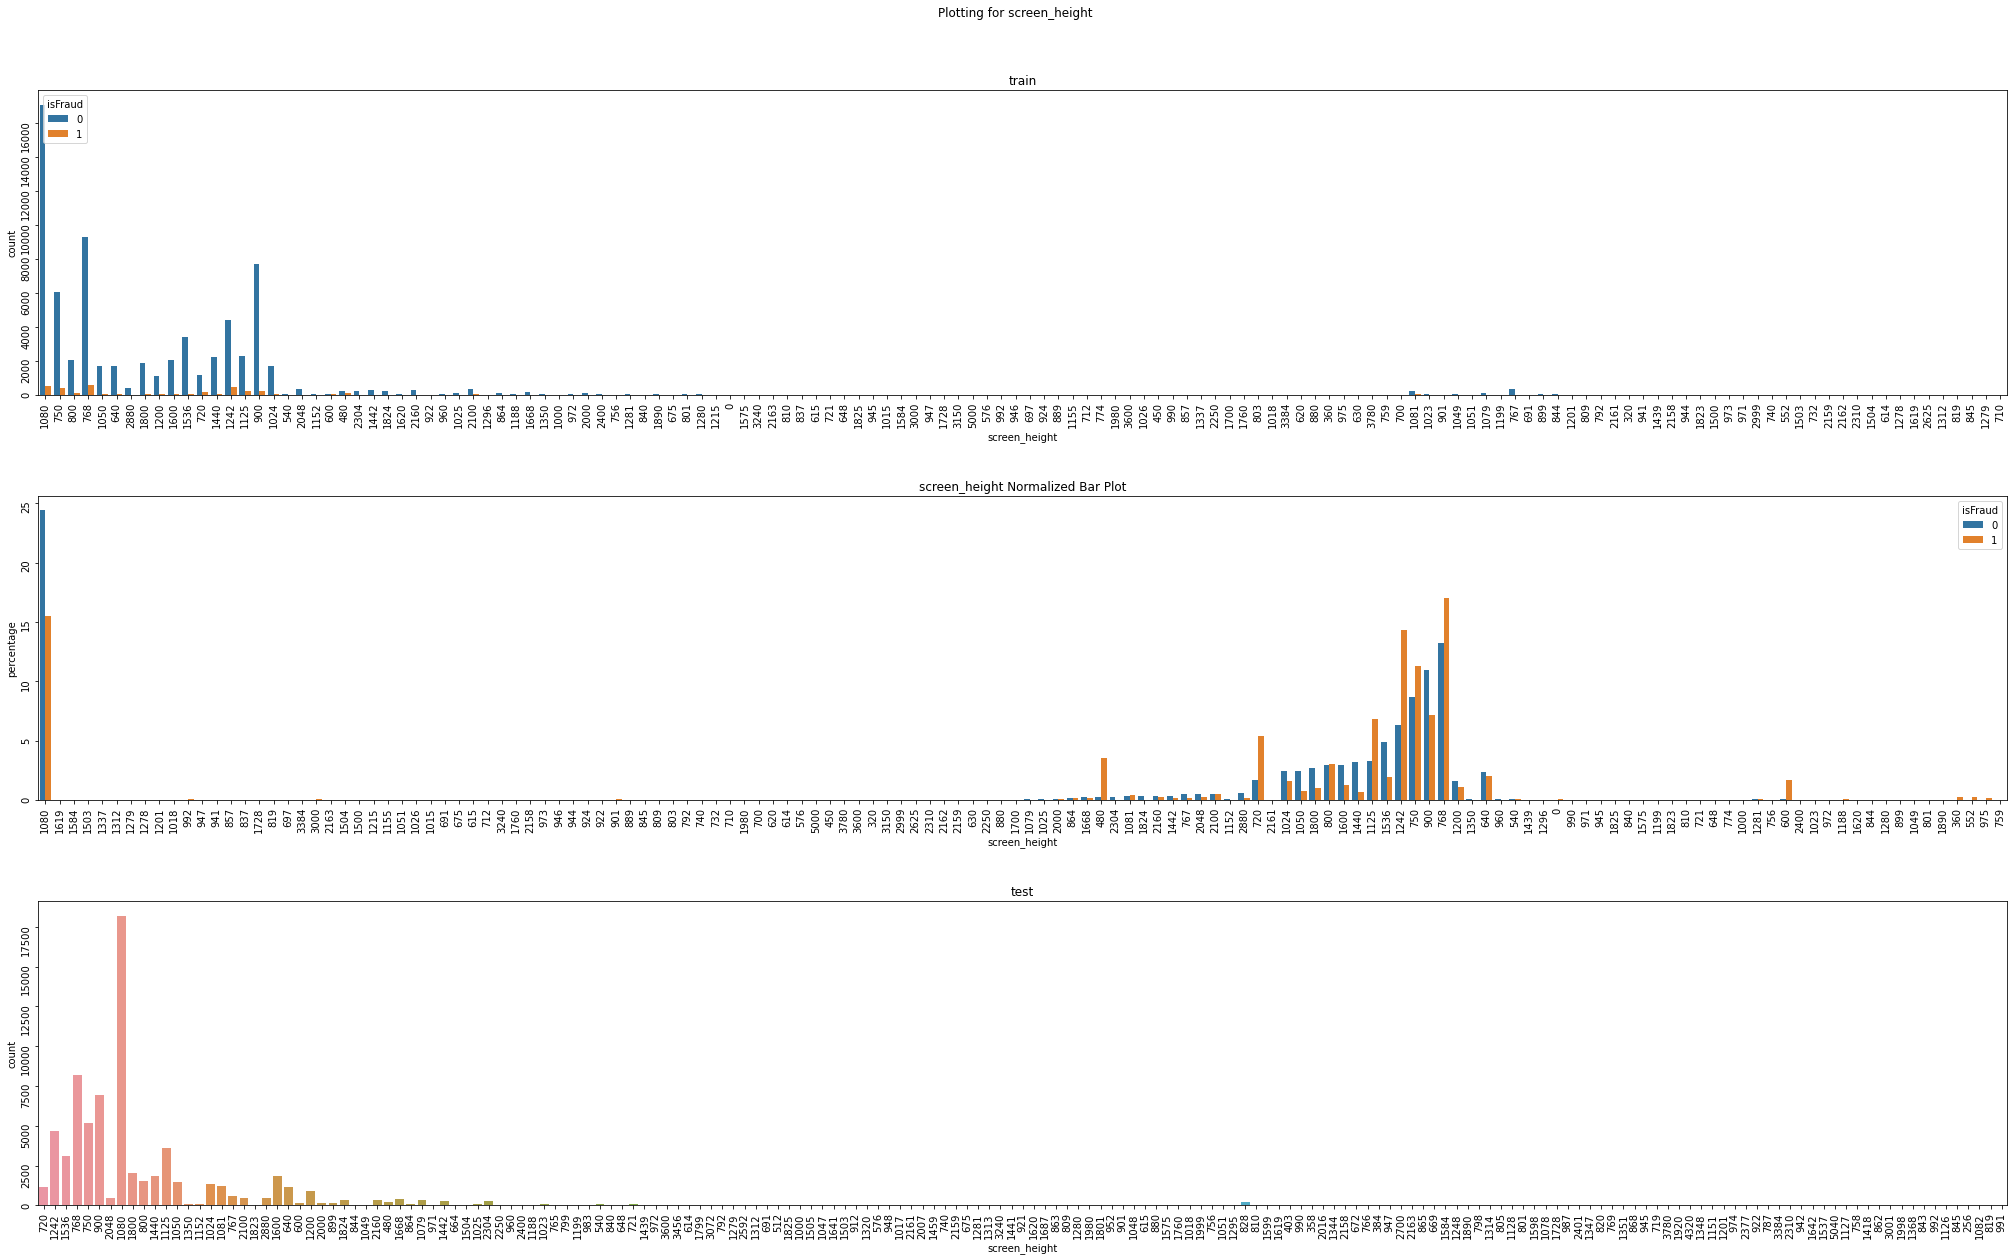

In [63]:
fig, ax = plt.subplots(3,1, figsize=(30,18))
fig.tight_layout(pad=8.0)
fig.suptitle("Plotting for screen_height", y=1)

ax[0].set_title('train')
sns.countplot(x='screen_height', hue='isFraud', data=train_data, ax=ax[0])
ax[0].tick_params(rotation=90)

ax[1].set_title("screen_height Normalized Bar Plot")
sns.barplot(x="screen_height", y="percentage", hue="isFraud", data=norm_screen_height, ax=ax[1])
ax[1].tick_params(rotation=90)

ax[2].set_title("test")
sns.countplot(x="screen_height", data=test_data, ax=ax[2])
ax[2].tick_params(rotation=90)

plt.show()

## Interaction Features

In [70]:
train_data['card_intr1'] = train_data['card1_div_1000'].astype(str) + " " + \
                           train_data['card2_div_10'].astype(str) + " " + \
                           train_data['card3'].astype(str) + " " + \
                           train_data['card5'].astype(str) + " " + \
                           train_data['card6'].astype(str)

test_data['card_intr1'] = test_data['card1_div_1000'].astype(str) + " " + \
                          test_data['card2_div_10'].astype(str) + " " + \
                          test_data['card3'].astype(str) + " " + \
                          test_data['card5'].astype(str) + " " + \
                          test_data['card6'].astype(str)

train_data['card_intr2'] = train_data['card1'].astype(str) + " " + \
                           train_data['card2'].astype(str) + " " + \
                           train_data['card3'].astype(str) + " " + \
                           train_data['card5'].astype(str) + " " + \
                           train_data['card6'].astype(str)

test_data['card_intr2'] = test_data['card1'].astype(str) + " " + \
                          test_data['card2'].astype(str) + " " + \
                          test_data['card3'].astype(str) + " " + \
                          test_data['card5'].astype(str) + " " + \
                          test_data['card6'].astype(str)

In [71]:
train_data['card1_addr1'] = train_data['card1'].astype(str)+train_data['addr1'].astype(str)
test_data['card1_addr1'] = test_data['card1'].astype(str)+test_data['addr1'].astype(str)

train_data['card1_addr2'] = train_data['card1'].astype(str)+train_data['addr2'].astype(str)
test_data['card1_addr2'] = test_data['card1'].astype(str)+test_data['addr2'].astype(str)

In [72]:
train_data['card2_addr1'] = train_data['card2'].astype(str)+train_data['addr1'].astype(str)
test_data['card2_addr1'] = test_data['card2'].astype(str)+test_data['addr1'].astype(str)

train_data['card2_addr2'] = train_data['card2'].astype(str)+train_data['addr2'].astype(str)
test_data['card2_addr2'] = test_data['card2'].astype(str)+test_data['addr2'].astype(str)

In [73]:
train_data['card3_addr1'] = train_data['card3'].astype(str)+train_data['addr1'].astype(str)
test_data['card3_addr1'] = test_data['card3'].astype(str)+test_data['addr1'].astype(str)

train_data['card3_addr2'] = train_data['card3'].astype(str)+train_data['addr2'].astype(str)
test_data['card3_addr2'] = test_data['card3'].astype(str)+test_data['addr2'].astype(str)

In [74]:
train_data['card5_addr1'] = train_data['card5'].astype(str)+train_data['addr1'].astype(str)
test_data['card5_addr1'] = test_data['card5'].astype(str)+test_data['addr1'].astype(str)

train_data['card5_addr2'] = train_data['card5'].astype(str)+train_data['addr2'].astype(str)
test_data['card5_addr2'] = test_data['card5'].astype(str)+test_data['addr2'].astype(str)

In [75]:
train_data['card6_addr1'] = train_data['card6'].astype(str)+train_data['addr1'].astype(str)
test_data['card6_addr1'] = test_data['card6'].astype(str)+test_data['addr1'].astype(str)

train_data['card6_addr2'] = train_data['card6'].astype(str)+train_data['addr2'].astype(str)
test_data['card6_addr2'] = test_data['card6'].astype(str)+test_data['addr2'].astype(str)

In [76]:
train_data['ProductCD_addr1'] = train_data['ProductCD'].astype(str)+train_data['addr1'].astype(str)
test_data['ProductCD_addr1'] = test_data['ProductCD'].astype(str)+test_data['addr1'].astype(str)

train_data['ProductCD_addr2'] = train_data['ProductCD'].astype(str)+train_data['addr2'].astype(str)
test_data['ProductCD_addr2'] = test_data['ProductCD'].astype(str)+test_data['addr2'].astype(str)

In [77]:
train_data['card1_ProductCD'] =train_data['card1'].astype(str)+train_data['ProductCD'].astype(str)
test_data['card1_ProductCD'] = test_data['card1'].astype(str)+test_data['ProductCD'].astype(str)

train_data['card2_ProductCD'] =train_data['card2'].astype(str)+train_data['ProductCD'].astype(str)
test_data['card2_ProductCD'] = test_data['card2'].astype(str)+test_data['ProductCD'].astype(str)

train_data['card5_ProductCD'] =train_data['card5'].astype(str)+train_data['ProductCD'].astype(str)
test_data['card5_ProductCD'] = test_data['card5'].astype(str)+test_data['ProductCD'].astype(str)

train_data['card6_ProductCD'] = train_data['card6'].astype(str)+train_data['ProductCD'].astype(str)
test_data['card6_ProductCD'] = test_data['card6'].astype(str)+test_data['ProductCD'].astype(str)

In [78]:
train_data['addr1_P_emaildomain'] = train_data['addr1'].astype(str)+train_data['P_emaildomain'].astype(str)
test_data['addr1_P_emaildomain'] = test_data['addr1'].astype(str)+test_data['P_emaildomain'].astype(str)

train_data['card1_P_emaildoman'] = train_data['card1'].astype(str)+train_data['P_emaildomain'].astype(str)
test_data['card1_P_emaildoman'] = test_data['card1'].astype(str)+test_data['P_emaildomain'].astype(str)

train_data['card1_addr1_P_emaildomain'] = train_data['card1'].astype(str)+train_data['addr1_P_emaildomain'].astype(str)
test_data['card1_addr1_P_emaildomain'] = test_data['card1'].astype(str)+test_data['addr1_P_emaildomain'].astype(str)

### Normalizing D_features

D_features corresponds to timedeltas like the number of days elapsed since the card began or the number of days since the first transaction etc.
<br><br>

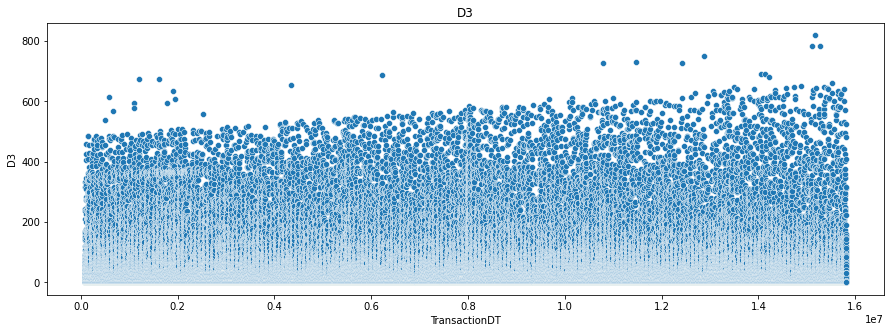

In [84]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='TransactionDT', y='D3', data=train_data)
plt.title('D3')
plt.show()

__Observation(s):__

Following Inferences can be made from the above plot,

1. D_features are increasing with time and it is quite obvious since each of the feature is timdelta which will definitly increase with time.


2. It would be much better if we have exact day instead of number of days elapsed and to get this info we can simply subtract TransactionDay from each of the D_features.
<br><br>

In [85]:
d_features = ["D"+str(i) for i in range(1,16) if "D"+str(i) in train_data.columns]

for f in d_features:
    train_data[f] =  train_data[f] - train_data['TransactionDay']
    test_data[f] = test_data[f] - test_data['TransactionDay']

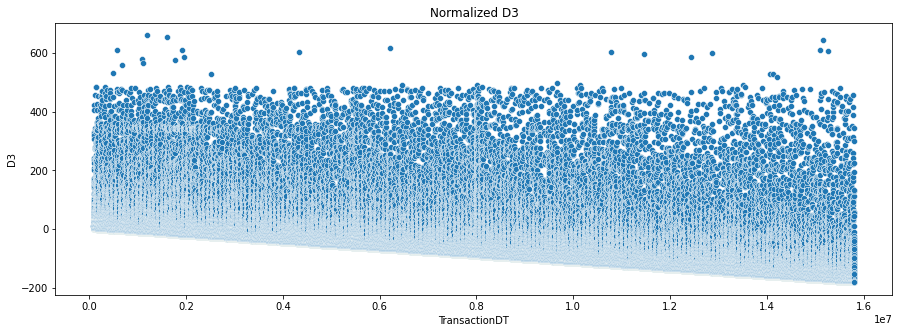

In [86]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='TransactionDT', y='D3', data=train_data)
plt.title('Normalized D3')
plt.show()

## Identifying the Card Holders
<br>

Based on the information given by the competition host, once a credit card is marked as fraud, it is not used again and hence we can say it in other words that once a Card Holder is marked as Fraud, it is no longer allowed to make any transactions using the same card. Hence, our actual objective is not to predict the Fraudulent Transactions instead our task is to predict the Fraudulent Clients.

Now, in order to do so we need to somehow identify the Card Holder based on the information given to us. From the data we can find various ways to identfy the client but none of the method is completely perfect since most of the columns are not revealed and hene we need to make a guess. Now, based on the analysis we have the following possibilities to identify a client,


1. __card1_card2_card3_card5_card6_addr1_P_emaildomain__ - Since, the card1-card6 feature corresponds to the information of cards, addr1 corresponds to the billing region and P_emaildomain is the purchaser domain.


2. __card1_addr1_P_emaildomain__ - Since, card1 has no missing values and has majority of unique values so this feature combined with addr1 which corrresponds to the region code and P_emaildomain would suffice.

There can be other possibilities too but we will going with these only for now.
<br><br>


In [87]:
train_data['uid1'] = train_data['card1'].astype(str)+train_data['card2'].astype(str)+\
                     train_data['card3'].astype(str)+train_data['card5'].astype(str)+\
                     train_data['card6'].astype(str)+train_data['addr1'].astype(str)+\
                     train_data['P_emaildomain'].astype(str)

test_data['uid1'] = test_data['card1'].astype(str)+test_data['card2'].astype(str)+\
                    test_data['card3'].astype(str)+test_data['card5'].astype(str)+\
                    test_data['card6'].astype(str)+test_data['addr1'].astype(str)+\
                    test_data['P_emaildomain'].astype(str)


train_data['uid2'] = train_data['card1'].astype(str)+train_data['addr1_P_emaildomain'].astype(str)
test_data['uid2'] = test_data['card1'].astype(str)+test_data['addr1_P_emaildomain'].astype(str)

In [88]:
print("*"*35)
print("\n Train Data Shape : {} \n".format(train_data.shape))
print("\n Test Data Shape : {} \n".format(test_data.shape))
print("*"*35)

***********************************

 Train Data Shape : (590538, 208) 


 Test Data Shape : (506691, 207) 

***********************************


In [89]:
# Saving the Feature Engineered Datasets

train_data.to_pickle('basic_fe_train.pkl')
test_data.to_pickle('basic_fe_test.pkl')